## Getting the keys and installation

1. In order to get trial keys for Spark NLP for Healthcare
, fill the form at https://www.johnsnowlabs.com/spark-nlp-try-free/ and you will get your keys to your email in a few minutes.
2. On a new cluster or existing one
  - add the following to the `Advanced Options -> Spark` tab, in `Spark.Config` box:
    ```bash
    spark.local.dir /var
    spark.kryoserializer.buffer.max 1000M
    spark.serializer org.apache.spark.serializer.KryoSerializer
    ```
  - add the following to the `Advanced Options -> Spark` tab, in `Environment Variables` box:
    ```bash
    AWS_ACCESS_KEY_ID=xxx
    AWS_SECRET_ACCESS_KEY=yyy
    SPARK_NLP_LICENSE=zzz
    ```
3. Download the followings with AWS CLI to your local computer

    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl-$jsl_version.jar spark-nlp-jsl-$jsl_version.jar`
    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl/spark_nlp_jsl-$jsl_version-py3-none-any.whl spark_nlp_jsl-$jsl_version-py3-none-any.whl` 
    
4. In `Libraries` tab inside your cluster:

 - Install New -> PyPI -> `spark-nlp==$public_version` -> Install
 - Install New -> Maven -> Coordinates -> `com.johnsnowlabs.nlp:spark-nlp_2.12:$public_version` -> Install
 - add following jars for the Healthcare library that you downloaded above:
        - Install New -> Python Whl -> upload `spark_nlp_jsl-$jsl_version-py3-none-any.whl`
        - Install New -> Jar -> upload `spark-nlp-jsl-$jsl_version.jar`
        
5. Now you can attach your notebook to the cluster and use Spark NLP!

For more information, see 
  https://nlp.johnsnowlabs.com/docs/en/install#databricks-support
  https://nlp.johnsnowlabs.com/docs/en/licensed_install#install-spark-nlp-for-healthcare-on-databricks

# Abstracting Real World Data from Oncology Notes
MT ONCOLOGY NOTES comprises of millions of ehr records of patients. It contains structured data like demographics, insurance details, and a lot more, but most importantly, it also contains free-text data like real encounters and notes.

### Goal: We'll see how we can use Spark NLP's existing models to process raw text and extract highly specialized cancer information for various use cases.

- Staff demand analysis according to specialties.
- Preparing reimbursement-ready data with billable codes.
- Analysis of risk factors of patients and symptoms.
- Analysis of cancer disease and symptoms.
- Drug usage analysis for inventory management.
- Preparing timeline of procedures.
- Relations between internal body part and procedures.
- Analysis of procedures used on oncological events.
- Checking assertion status of oncological findings.

Let's import the libraries which we will use in the following cells.

In [0]:
import os
import json
import string
import numpy as np
import pandas as pd

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from sparknlp.training import CoNLL

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

print('sparknlp.version : ',sparknlp.version())
print('sparknlp_jsl.version : ',sparknlp_jsl.version())

spark


sparknlp.version : 3.0.3
sparknlp_jsl.version : 3.1.0rc1
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

**Read Dataset**

**!!! Warning :** This notebook is optimized to run in Databricks CE. If you want to test the same Spark NLP for Helathcare modules with large data, please consider upgrading to larger DBUs. Also this notebook can only work with Spark NLP for Healthcare `v3.1.0` an above. If you have previous versions, please consider upgrading your version.

In [0]:
%sh
for i in {0..2}
do
 wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/oncology_notes/mt_oncology_$i.txt
done

In [0]:
notes_path='file:/databricks/driver/mt_oncology_*.txt'



textFiles = spark.sparkContext.wholeTextFiles(notes_path)

df = textFiles.toDF(schema=['path','text'])

**Vizualize the Entities Using Spark NLP Display Library**

At first, we will create a NER pipeline. And then, we can see the labbeled entities on text.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("bionlp_ner")

bionlp_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "bionlp_ner"]) \
  .setOutputCol("bionlp_ner_chunk")\
  .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("jsl_ner_wip_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")\
  .setWhiteList(["Oncological", "Symptom", "Treatment"])

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][ / ][ — ][ \ ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][ — ][OK!]

We used two diiferent NER model (`jsl_ner_wip_clinical` and `bionlp_ner`) and we need to merge the by a chunk merger. There are two different entities related to oncology. So we will change `Cancer` entities to `Oncological` by `setReplaceDictResource` parameter. This parameter gets the list from a csv file. Before merging the entities, we are creating the csv file with a row `Cancer,Oncological`.

In [0]:
replace_dict = 'Cancer,Oncological'
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)
    
dbutils.fs.cp("file:/databricks/driver/replace_dict.csv", "dbfs:/", recurse=True)

Out[5]: True

In [0]:
chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource("dbfs:/replace_dict.csv","text", {"delimiter":","})
 
ner_pipeline= Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger])
empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `icd10_model`.

In [0]:
sample_text = df.limit(1).select("text").collect()[0]

In [0]:
light_model =  LightPipeline(ner_model)
 
ann_text = light_model.fullAnnotate(sample_text)[0]
ann_text.keys()

Out[13]: dict_keys(['document', 'final_ner_chunk', 'jsl_ner_chunk', 'bionlp_ner', 'jsl_ner', 'token', 'embeddings', 'sentence', 'bionlp_ner_chunk'])

In [0]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'ONCOLOGICAL':'#ff2e51', 'TREATMENT': '#0A902E', 'SYMPTOM': '#7D087D' })

ner_vis = visualiser.display(ann_text, label_col='final_ner_chunk',return_html=True)

displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Consult - Breast Cancer Oncological Description: Patient presents with complaint of lump Symptom in the upper outer quadrant of the right breast Oncological (Medical Transcription Sample Report) CHIEF COMPLAINT / REASON FOR THE VISIT: Patient has been diagnosed to have breast cancer Oncological . BREAST CANCER HISTORY: Patient presented with the following complaints: Lump in the upper outer quadrant of the right breast Symptom that has been present for the last 4 weeks. The lump Symptom is painless and the skin over the lump Symptom is normal. Patient denies any redness Symptom , warmth Symptom , edema Symptom and nipple discharge Symptom . Patient had a mammogram recently and was told to have a mass Symptom measuring 2 cm in the UOQ and of the left breast. Patient had an excisional biopsy of the mass Symptom and subsequently axillary nodal sampling. PATHOLOGY: Infiltrating ductal carcinoma Oncological , Estrogen receptor 56, Progesterone receptor 23, S-phase fraction 2., Her 2 neu 0 and all nodes negative. STAGE: Stage I. TNM STAGE: T1, N0 and M0. SURGERY: S/P lumpectomy left breast and Left axillary node sampling. Patient is here for further recommendation. PAST MEDICAL HISTORY: Osteoarthritis for 5 years. ASHD for 10 years. Kidney stones recurrent for 10 years. SCREENING TEST HISTORY: Last rectal exam was done on 10/99. Last mammogram was done on 12/99. Last gynecological exam was done on 10/99. Last PAP smear was done on 10/99. Last chest x-ray was done on 10/99. Last F.O.B. was done on 10/99-X3. Last sigmoidoscopy was done on 1998. Last colonoscopy was done on 1996. IMMUNIZATION HISTORY: Last flu vaccine was given on 1999. Last pneumonia vaccine was given on 1996. FAMILY MEDICAL HISTORY: Father age 85, history of cerebrovascular accident (stroke) and hypertension. Mother history of CHF and emphysema that died at the age of 78. No brothers and sisters. 1 son healthy at age 54. PAST SURGICAL HISTORY: Appendectomy. Biopsy of the left breast 1996 - benign. Cholecystectomy. PERSONAL AND SOCIAL HISTORY: Marital status: Married. Smoking history: Smoked 1 PPD, quit 12 years ago and after smoking for 30 years. Alcohol history: Drinks socially. Denies any history of drug abuse. ALLERGIES: There are no known drug allergies. CURRENT MEDICATIONS: Aspirin 1 tab x 1 / day. Calan SR 120 mg. x 1 / day. REVIEW OF SYSTEMS: General: Patient feels fairly well. Patient denies history of fever, chills Symptom , night sweats Symptom and weight loss Symptom . Head and Eyes: Patient denies any problems relating to the head and eyes. Ears Nose and Throat: Patient has no problems related to the ears, nose or throat. Respiratory: Patient denies any respiratory complaints Symptom , such as cough Symptom , shortness of breath Symptom , chest pain Symptom , wheezing Symptom , hemoptysis Symptom , etc. Cardiovascular: Chest pain Symptom in the retrosternal area, Occasional anginal pain Symptom and patient describes it as a sensation of tightness Symptom . It radiates to the left shoulder. Patient denies any palpitation Symptom , syncope Symptom , paroxysmal nocturnal dyspnea Symptom and orthopnea Symptom . Gastrointestinal: Patient denies any nausea Symptom , vomiting Symptom , abdominal pain Symptom , dysphagia Symptom or any altered bowel movements Symptom . Genitourinary: Denies any genito-urinary complaints Symptom . Musculoskeletal: The patient denies any musculoskeletal complaints Symptom . Neurological: Patient denies any focal motor, sensory or other neurological symptoms Symptom . PHYSICAL EXAMINATION: General: Patient appears well developed, well nourished and healthy. Personality: pleasant and cooperative. Mental status: Alert and oriented. Stature: slender. ECOG performance score 0. HEENT: Examination of head, eyes, ears, nose and throat is unremarkable. Hematologic / Lymphatic: There is no palpable adenopathy Symptom in the inguinal, axillary, or cervical areas. Cardiovascul

# 1. Get ICD-10 codes using entity resolvers and use the data for various use cases.

We can use hcc_billable entity resolver to get ICD10-CM codes for identified entities. The unique this about this resolver is it also provides HCC risk factor and billable status for each ICD code. We can use this information for a lot of tasks.

We are inserting `sbiobert_base_cased_mli` embedding and `sbiobertresolve_icd10cm_augmented_billable_hcc` resolver.

In [0]:
chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource("dbfs:/replace_dict.csv","text", {"delimiter":","})

c2doc = Chunk2Doc()\
  .setInputCols("final_ner_chunk")\
  .setOutputCol("final_ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["final_ner_chunk_doc"])\
  .setOutputCol("sentence_embeddings")

icd10_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models")\
  .setInputCols(["final_ner_chunk", "sentence_embeddings"]) \
  .setOutputCol("icd10_code")\
  .setDistanceFunction("EUCLIDEAN")

bert_pipeline_icd10cm = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        c2doc, 
        sbert_embedder,
        icd10_resolver])
empty_data = spark.createDataFrame([['']]).toDF("text")
icd10_model = bert_pipeline_icd10cm.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
demo_sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.4 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]

**Now we will transform our dataframe by using `icd10_model` and get the ICD10CM codes of the entities.**

In [0]:
icd10_hcc_res = icd10_model.transform(df)

In [0]:
icd10_hcc_df = icd10_hcc_res.select("path", F.explode(F.arrays_zip('final_ner_chunk.result', 
                                                                   'final_ner_chunk.metadata', 
                                                                   'icd10_code.result', 
                                                                   'icd10_code.metadata')).alias("cols")) \
                            .select("path", F.expr("cols['0']").alias("final_chunk"),
                                     F.expr("cols['1']['entity']").alias("entity"), 
                                     F.expr("cols['2']").alias("icd10_code"),
                                     F.expr("cols['3']['confidence']").alias("confidence"),
                                     F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                     F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                     F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(icd10_hcc_df['all_codes'], icd10_hcc_df['resolutions'], icd10_hcc_df['hcc_list']):
    
    codes.append( code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

icd10_hcc_df['all_codes'] = codes  
icd10_hcc_df['resolutions'] = resolutions
icd10_hcc_df['hcc_list'] = hcc_all

The values in `billable`, `hcc_store` and `hcc_status` columns are seperated by `||` and we will change them to a list.

In [0]:
def extract_billable(bil):
  
  billable = []
  status = []
  score = []

  for b in bil:
    billable.append(b.split("||")[0])
    status.append(b.split("||")[1])
    score.append(b.split("||")[2])

  return (billable, status, score)

icd10_hcc_df["hcc_status"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_hcc_df["hcc_score"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]
icd10_hcc_df["billable"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]

icd10_hcc_df.drop("hcc_list", axis=1, inplace= True)
icd10_hcc_df['icd_codes_names'] = icd10_hcc_df['resolutions'].apply(lambda x : x[0])
icd10_hcc_df['icd_code_billable'] = icd10_hcc_df['billable'].apply(lambda x : x[0])

In [0]:
icd10_hcc_df.head()

Out[19]:

,path,final_chunk,entity,icd10_code,confidence,all_codes,resolutions,hcc_status,hcc_score,billable,icd_codes_names,icd_code_billable
0,file:/databricks/driver/mt_oncology_2.txt,Breast Cancer,Oncological,C5092,0.5748,"[C5092, C509, C5091, D493, C5061]","[breast cancer, carcinoma of breast, ca - breast cancer, breast tumor, carcinoma of breast - axi...","[1, 0, 1, 0, 1]","[12, 0, 12, 0, 12]","[0, 0, 0, 1, 0]",breast cancer,0
1,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,R229,0.9989,"[R229, R688, Q182, R251, R098, R220, R221, M303, R2230, Z9189, H0001, R609, R468, B740, M329, D2...","[lump, o/e - a lump, wattle, shakes, bruit, lump on face, lump on neck, mcls, lump on finger, im...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 40, 0, 19, 0]","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]",lump,1
2,file:/databricks/driver/mt_oncology_2.txt,breast,Oncological,Z978,0.2457,"[Z978, R928, P390, N63, N6452, Z9882, N645, N630, N611, N61, E65, N6459, Q831, N649]","[breast present, breast composition, furuncle of breast, breast mass, breast discharge, breast p...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]",breast present,1
3,file:/databricks/driver/mt_oncology_2.txt,breast cancer,Oncological,C5092,0.9889,"[C5092, C5091, D493, C509, N649, Z1239, D486, C5061]","[breast cancer, ca - breast cancer, breast tumor, carcinoma of breast, breast disease, suspected...","[1, 1, 0, 0, 0, 0, 0, 1]","[12, 12, 0, 0, 0, 0, 0, 12]","[0, 0, 1, 0, 1, 1, 0, 0]",breast cancer,0
4,file:/databricks/driver/mt_oncology_2.txt,Lump in the upper outer quadrant of the right breast,Symptom,C5041,0.4471,"[C5041, N6311, N6312, C5021, N6331, N63, C5011, N6310, N6314, C5051, C5031]","[lump in upper outer quadrant of right breast, lump in upper outer quadrant of right breast (fin...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]","[12, 0, 0, 12, 0, 0, 12, 0, 0, 12, 12]","[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]",lump in upper outer quadrant of right breast,0


We have three different entities in the dataframe.

In [0]:
icd10_hcc_df["entity"].value_counts()

Out[20]: Symptom 101
Oncological 17
Treatment 6
Name: entity, dtype: int64

Out[21]:

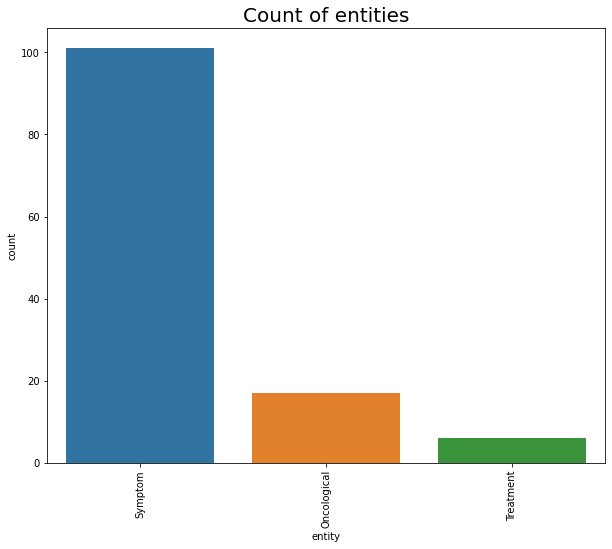

<matplotlib.axes._subplots.AxesSubplot at 0x7fc66af7f340>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.title("Count of entities", size=20)
sns.countplot(icd10_hcc_df.entity, order=icd10_hcc_df["entity"].value_counts().index)


## 1.1. Get general information for staff management, reporting, & planning.

Let's map diagnosis codes to parent categories to see which indications have most cases. 

We have defined a function and applied it to `icd10_code`.

In [0]:
icd10_oncology_mapping = {"C81-C96": "Malignant neoplasms of lymphoid, hematopoietic and related tissue",
                          "C76-C80": "Malignant neoplasms of ill-defined, other secondary and unspecified sites",
                          "D00-D09": "In situ neoplasms",
                          "C51-C58": "Malignant neoplasms of female genital organs",
                          "C43-C44": "Melanoma and other malignant neoplasms of skin",
                          "C15-C26": "Malignant neoplasms of digestive organs",
                          "C73-C75": "Malignant neoplasms of thyroid and other endocrine glands",
                          "D60-D64": "Aplastic and other anemias and other bone marrow failure syndromes",
                          "E70-E88": "Metabolic disorders",
                          "G89-G99": "Other disorders of the nervous system",
                          "R50-R69": "General symptoms and signs",
                          "R10-R19": "Symptoms and signs involving the digestive system and abdomen",
                          "Z00-Z13": "Persons encountering health services for examinations"}


def map_to_parent(x):
    charcode = x[0].lower()
    numcodes = int(x[1])
    
    for k, v in icd10_oncology_mapping.items():
        
        lower, upper = k.split('-')
        
        if charcode >= lower[0].lower() and numcodes >= int(lower[1]):
            
            if charcode < upper[0].lower():
                return v
            elif charcode == upper[0].lower() and numcodes <= int(upper[1]):
                return v

In [0]:
icd10_hcc_df["onc_code_desc"] = icd10_hcc_df["icd10_code"].apply(map_to_parent).fillna("-")
icd10_hcc_df.onc_code_desc.value_counts()

Out[27]: - 76
Symptoms and signs involving the digestive system and abdomen 18
General symptoms and signs 14
Melanoma and other malignant neoplasms of skin 5
Malignant neoplasms of female genital organs 5
Malignant neoplasms of lymphoid, hematopoietic and related tissue 3
In situ neoplasms 1
Metabolic disorders 1
Malignant neoplasms of digestive organs 1
Name: onc_code_desc, dtype: int64

**Lets plot a countplot to see the number of each parent categories.**

Out[28]:

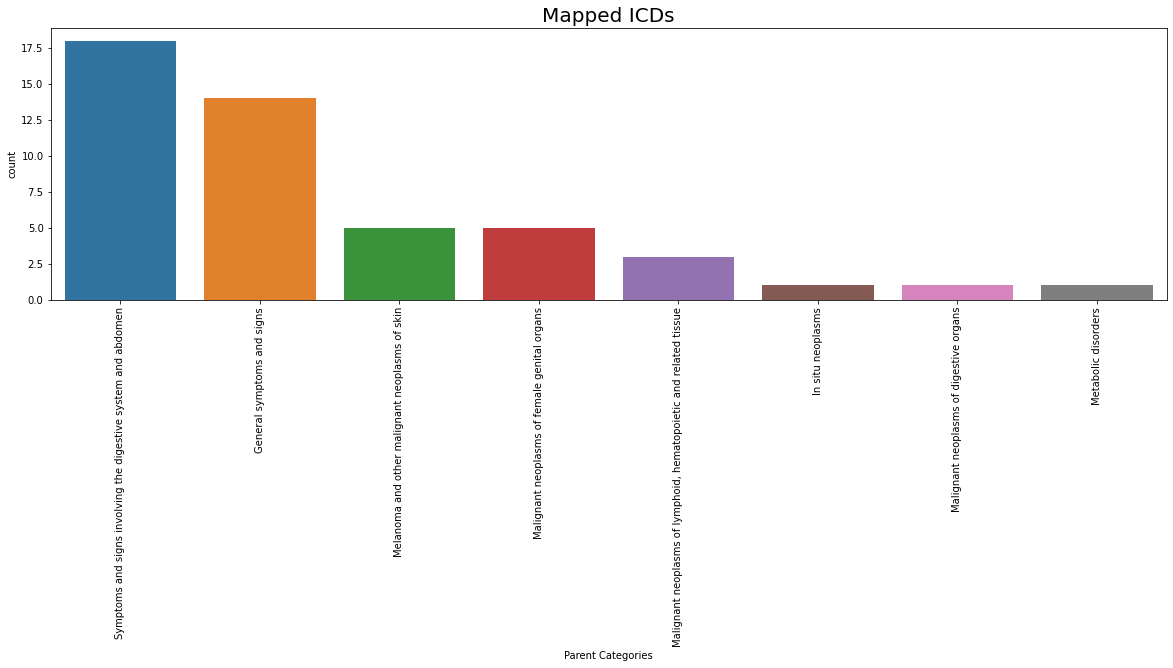

Text(0.5, 0, 'Parent Categories')

In [0]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
temp_df = icd10_hcc_df[icd10_hcc_df.onc_code_desc != "-"]

sns.countplot(temp_df.onc_code_desc, order=temp_df.onc_code_desc.value_counts().index)
plt.title("Mapped ICDs", size=20)
plt.xlabel("Parent Categories")

## 1.2. Preparing reimbursement-ready data with billable codes

Here, we will check how many of the ICD codes are billable.

In [0]:
print(icd10_hcc_df['icd_code_billable'].value_counts())

1 93
0 31
Name: icd_code_billable, dtype: int64

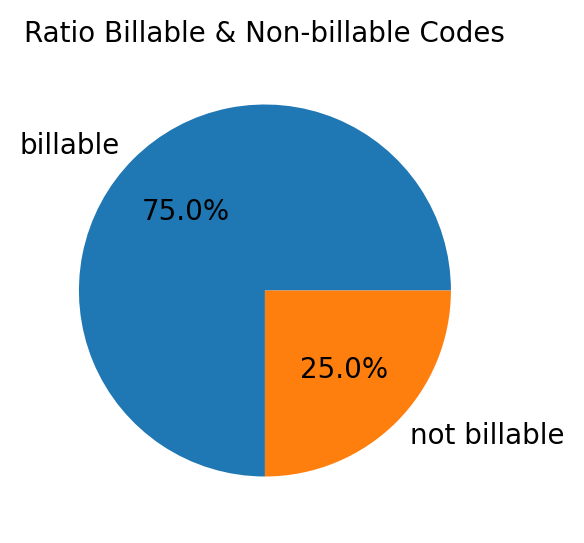

In [0]:
plt.figure(figsize=(3,4), dpi=200)
plt.pie(icd10_hcc_df['icd_code_billable'].value_counts(), 
        labels = ["billable", "not billable"], 
        autopct = "%1.1f%%"
       )
plt.title("Ratio Billable & Non-billable Codes", size=10)
plt.show()

**As we can see, some of the best matching codes are not billable. For such indications we can find codes that are relevant as well as billable.**

In [0]:
best_paid_icd_matches = []
indication_with_no_billable_icd = []

for i_, row in icd10_hcc_df.iterrows():
    if '1' not in row['billable']:
        indication_with_no_billable_icd.append([row['final_chunk'], 
                                      row['resolutions'][0], 
                                      row['all_codes'][0],
                                      row['billable'][0],
                                      row['hcc_score'][0],
                                      row['onc_code_desc'], 
                                      "-" ])
    else:
        n_zero_ind = row['billable'].index('1')
        best_paid_icd_matches.append([row['final_chunk'], 
                                      row['resolutions'][n_zero_ind], 
                                      row['all_codes'][n_zero_ind],
                                      row['billable'][n_zero_ind],
                                      row['hcc_score'][n_zero_ind],
                                      row['onc_code_desc'],
                                      n_zero_ind])

best_icd_mapped = pd.DataFrame(best_paid_icd_matches, columns=['ner_chunk', 'code', 'code_desc', 'billable', 
                                             'corresponding_hcc_score', 'onc_code_desc', 'nearest_billable_code_pos'])
best_icd_mapped['corresponding_hcc_score'] = pd.to_numeric(best_icd_mapped['corresponding_hcc_score'], errors='coerce')

best_icd_mapped.head()

Out[31]:

,ner_chunk,code,code_desc,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
0,Breast Cancer,breast tumor,D493,1,0,Malignant neoplasms of female genital organs,3
1,lump,lump,R229,1,0,-,0
2,breast,breast present,Z978,1,0,-,0
3,breast cancer,breast tumor,D493,1,0,Malignant neoplasms of female genital organs,2
4,Lump in the upper outer quadrant of the right breast,lump in upper outer quadrant of right breast (finding),N6311,1,0,Malignant neoplasms of female genital organs,1


**All chunks have been mapped to payable ICD codes**

In [0]:
print(best_icd_mapped.billable.value_counts())

1 124
Name: billable, dtype: int64

In [0]:
print("Number of non-billable ICD Codes: ",len(indication_with_no_billable_icd))

Number of non-billable ICD Codes: 0

**Lets take a look at the position of nearest codes that was taken for making billable**

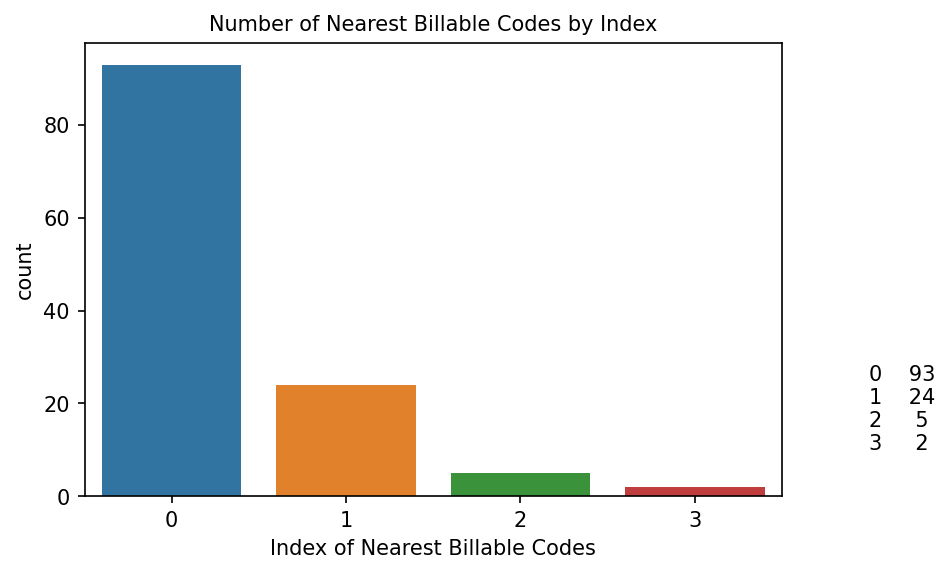

In [0]:
plt.figure(figsize=(6,4), dpi=150)
sns.countplot(best_icd_mapped['nearest_billable_code_pos'], order = best_icd_mapped.nearest_billable_code_pos.value_counts().index)
plt.title("Number of Nearest Billable Codes by Index", size=10)
plt.xlabel("Index of Nearest Billable Codes", size=10)
plt.text(4, 10, best_icd_mapped.nearest_billable_code_pos.value_counts().to_string())

plt.show()

## 1.3. See which indications have highest average risk factor

In our pipeline we used `demo_sbiobertresolve_icd10cm_augmented_billable_hcc` as Sentence resolver. So the model return HCC codes. We can calculate the risk per indication by getting the averages.

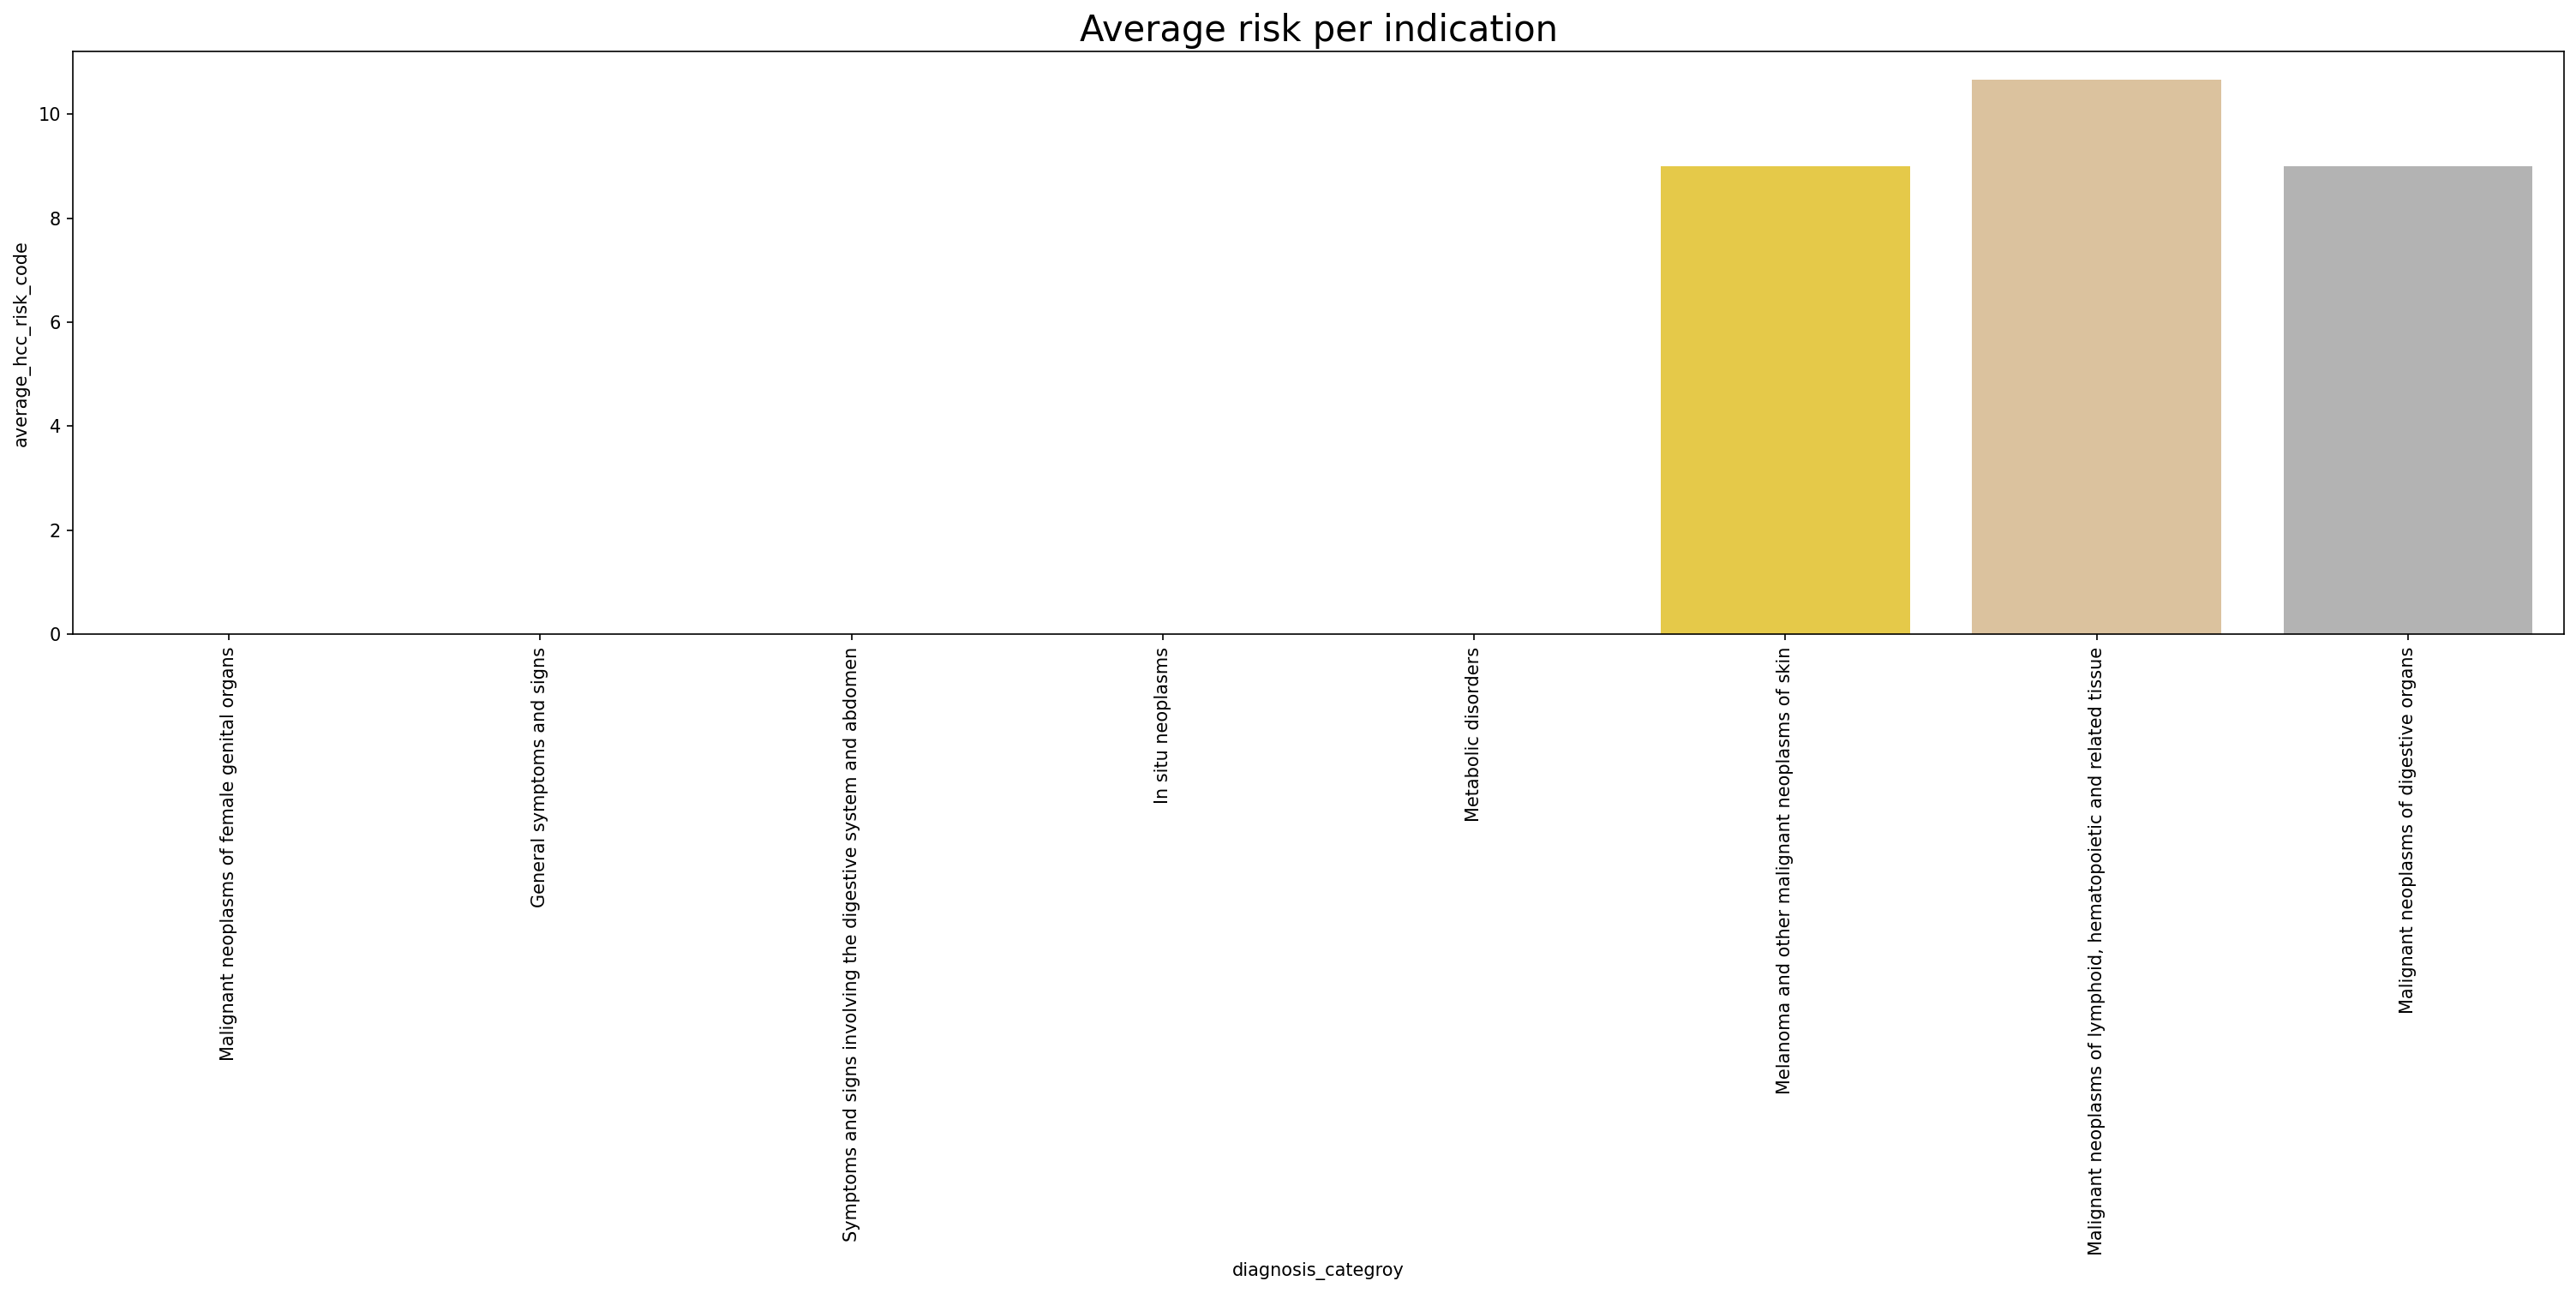

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(25,6), dpi=150)

sns.barplot(x='onc_code_desc', y='corresponding_hcc_score',
            data = best_icd_mapped[best_icd_mapped.onc_code_desc != "-"], ci = None,
            palette="Set2")

plt.title('Average risk per indication', size=20)
plt.xlabel('diagnosis_categroy')
plt.ylabel('average_hcc_risk_code')
plt.xticks(rotation=90)
plt.show()


**As we can see, some categories, even with fewer cases, have higher risk factor.**

## 1.4. Analyze Oncological Entities
We can find the most frequent oncological entities.

In [0]:
onc_df = icd10_hcc_df[icd10_hcc_df.entity=="Oncological"].iloc[:, [0,1,2,3,10,11]]
onc_df.head()

Out[36]:

,path,final_chunk,entity,icd10_code,icd_codes_names,icd_code_billable
0,file:/databricks/driver/mt_oncology_2.txt,Breast Cancer,Oncological,C5092,breast cancer,0
2,file:/databricks/driver/mt_oncology_2.txt,breast,Oncological,Z978,breast present,1
3,file:/databricks/driver/mt_oncology_2.txt,breast cancer,Oncological,C5092,breast cancer,0
13,file:/databricks/driver/mt_oncology_2.txt,Infiltrating ductal carcinoma,Oncological,C509,eccrine ductal carcinoma,0
41,file:/databricks/driver/mt_oncology_2.txt,Breast,Oncological,R928,breast composition,1


In [0]:
print(onc_df.icd_codes_names.value_counts().head(20))

mesothelioma 4
breast cancer 2
eccrine ductal carcinoma 2
breast present 1
cancer of stomach 1
cancer 1
oropharyngeal lesion 1
breast composition 1
cf 1
malignant mesothelioma 1
hematologic malignancy 1
lobular carcinoma in situ of left breast 1
Name: icd_codes_names, dtype: int64

Out[38]:

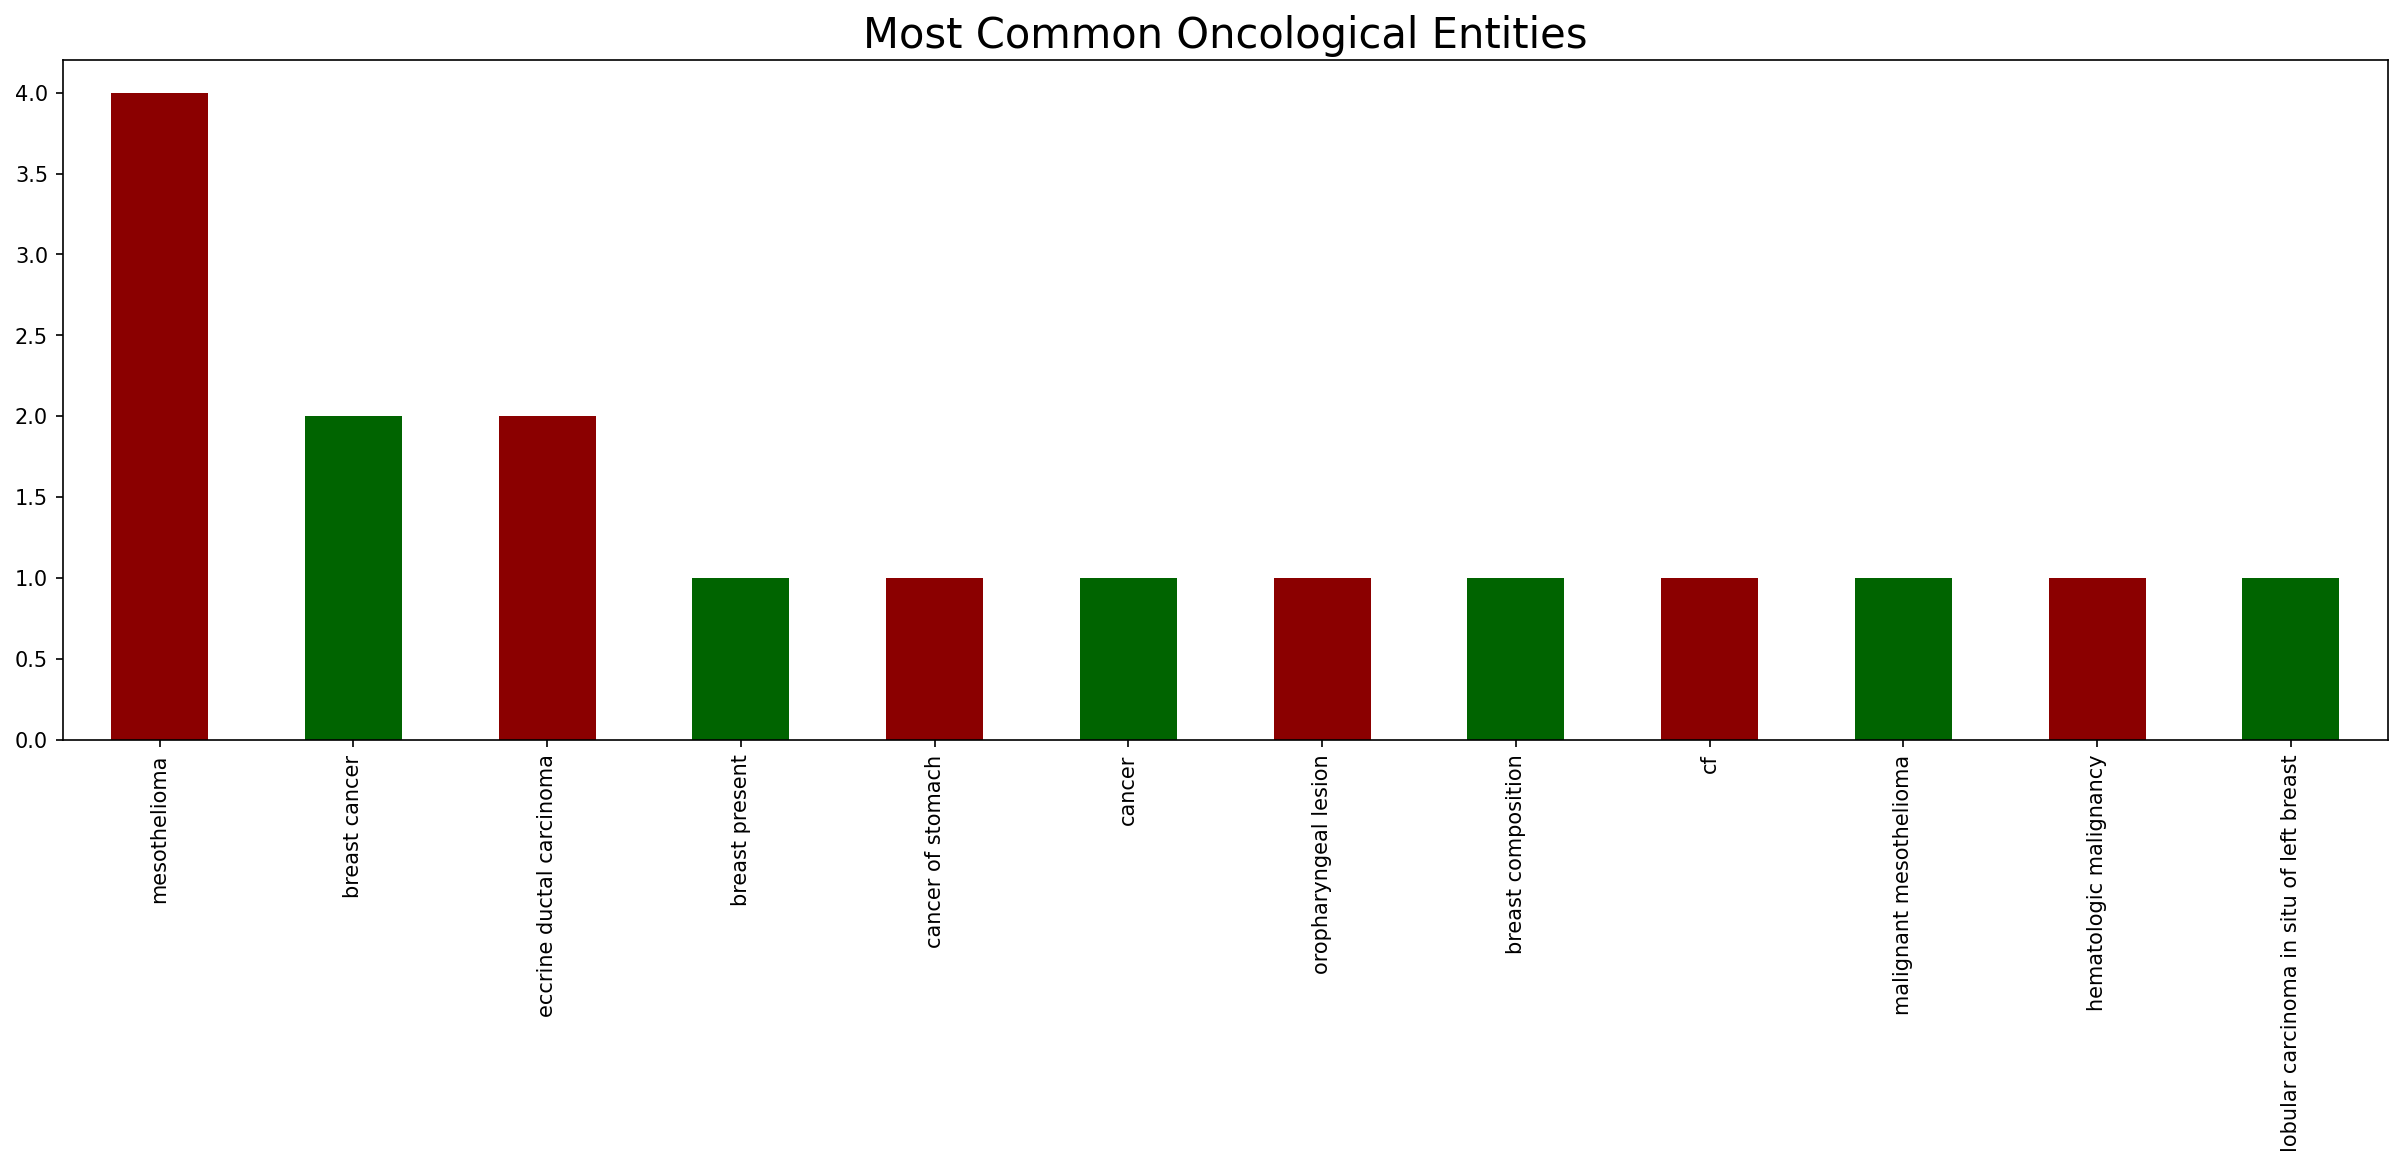

<matplotlib.axes._subplots.AxesSubplot at 0x7f35b09e39d0>

In [0]:
plt.figure(figsize=(20,6), dpi=150)
plt.xticks(rotation=90)
plt.title('Most Common Oncological Entities', size=20)
onc_df.icd_codes_names.value_counts().head(30).plot(kind='bar', color=['darkred', 'darkgreen'])

## 1.5. Report Counts by ICD10CM Code Names
Each bar shows count of reports contain the cancer entities.

In [0]:
most_common_icd_codes = onc_df.icd_codes_names.value_counts().index[:20]
print(most_common_icd_codes)

Index(['mesothelioma', 'breast cancer', 'eccrine ductal carcinoma',
 'breast present', 'cancer of stomach', 'cancer', 'oropharyngeal lesion',
 'breast composition', 'cf', 'malignant mesothelioma',
 'hematologic malignancy', 'lobular carcinoma in situ of left breast'],
 dtype='object')

Out[40]:

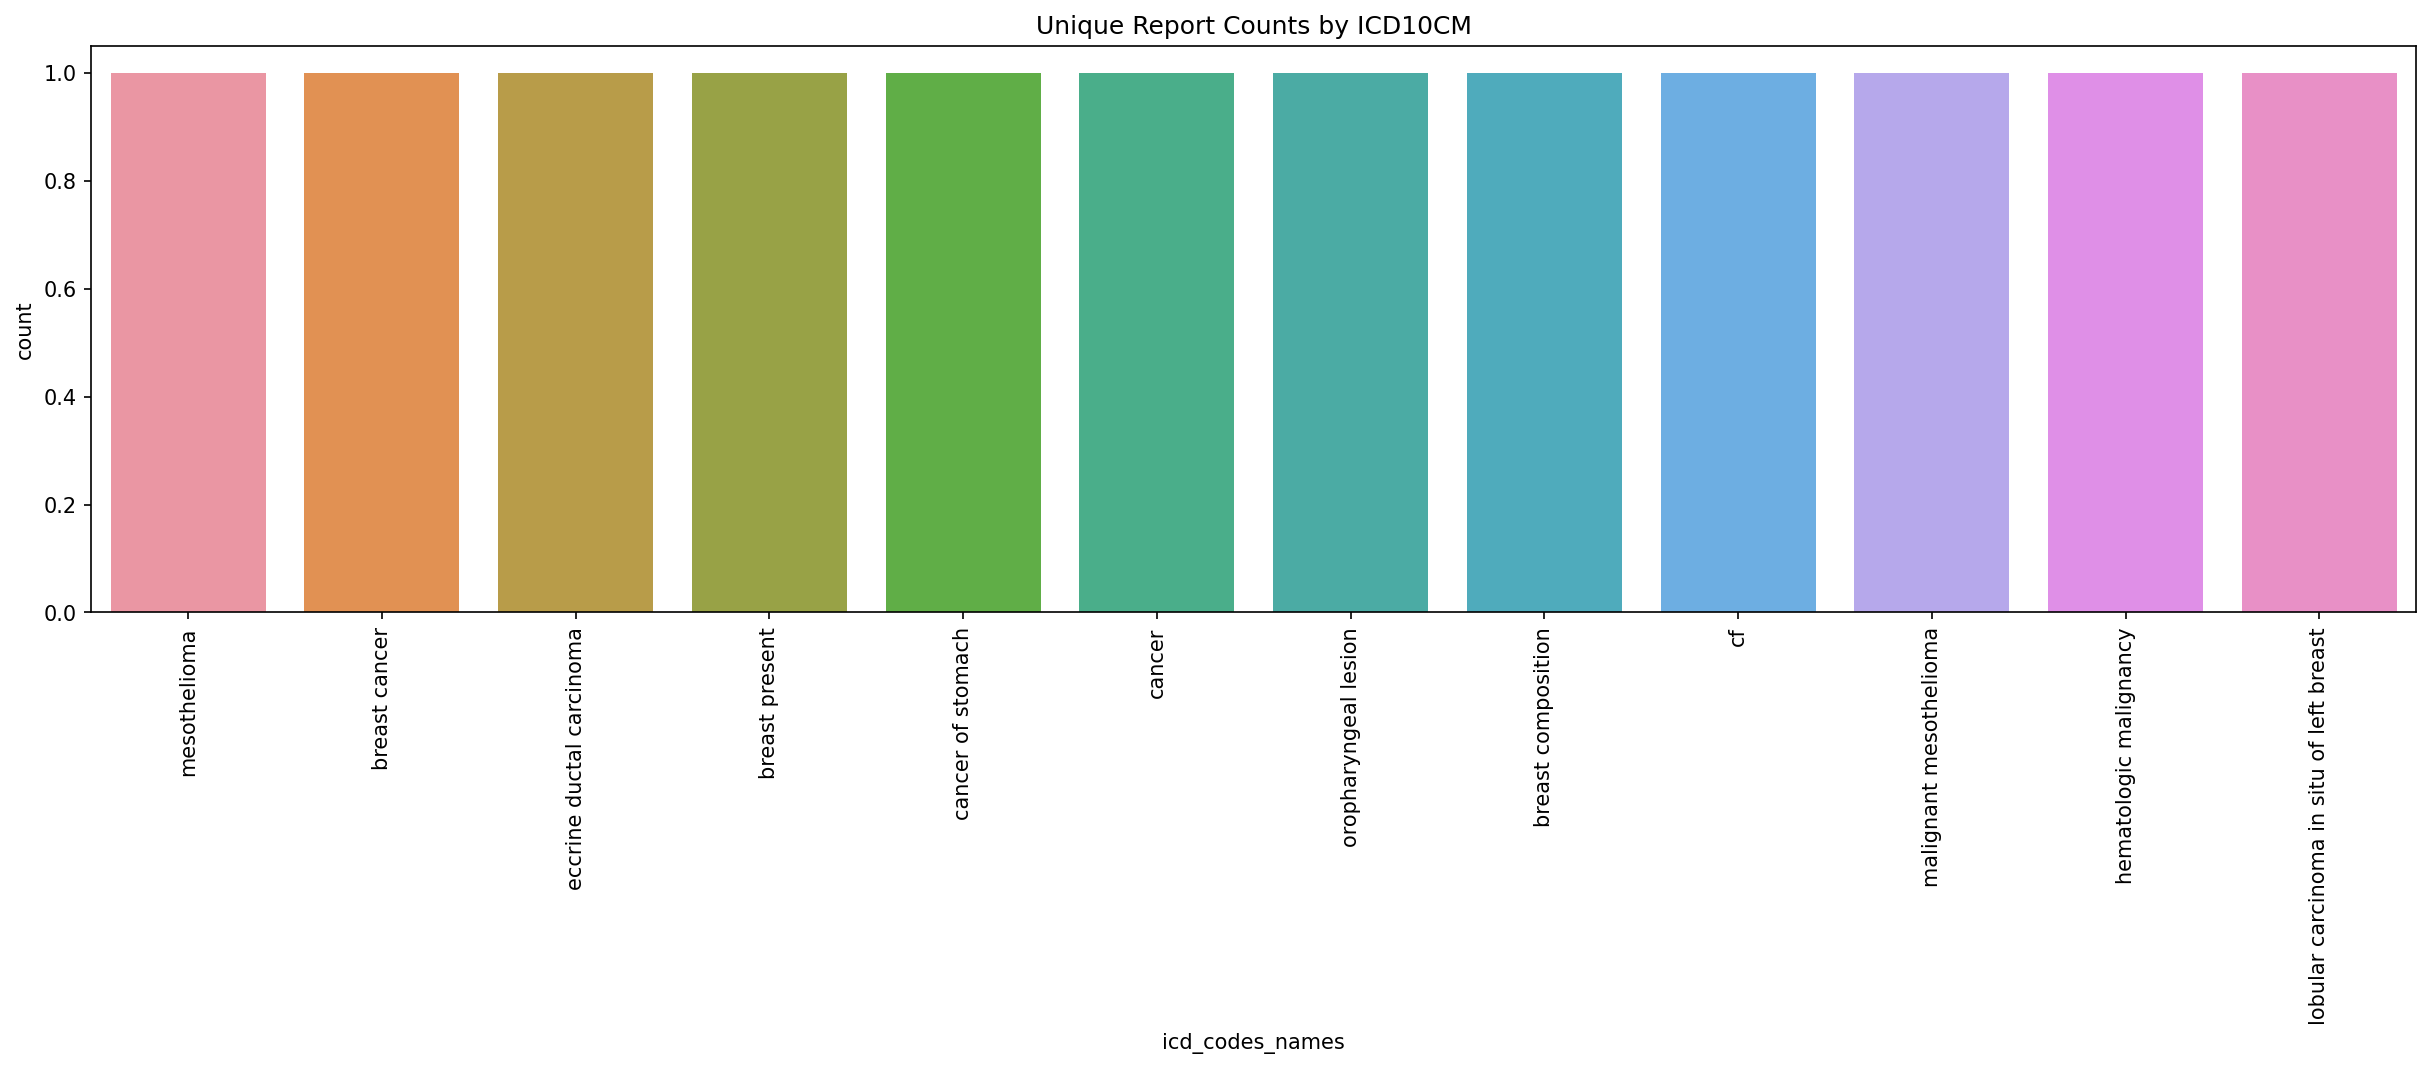

<matplotlib.axes._subplots.AxesSubplot at 0x7f35b0971280>

In [0]:
unique_icd_code_names = onc_df[onc_df.icd_codes_names.isin(most_common_icd_codes)].groupby(["path","icd_codes_names"]).count().reset_index()[["path","icd_codes_names"]]	

plt.figure(figsize=(20,5), dpi=150)
plt.xticks(rotation=90)
plt.title('Unique Report Counts by ICD10CM')

sns.countplot(unique_icd_code_names.icd_codes_names, order=most_common_icd_codes)

## 1.6. Most common symptoms
 We can find the most common symptoms counting the unique symptoms in documents.

In [0]:
symptom_df = icd10_hcc_df[icd10_hcc_df.entity.isin(["Symptom"])].iloc[:, [0,1,2,3,10,11]]
symptom_df.rename(columns={"icd_codes_names":"symptom"}, inplace=True)
symptom_df.head()

Out[41]:

,path,final_chunk,entity,icd10_code,symptom,icd_code_billable
1,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,R229,lump,1
4,file:/databricks/driver/mt_oncology_2.txt,Lump in the upper outer quadrant of the right breast,Symptom,C5041,lump in upper outer quadrant of right breast,0
5,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,R229,lump,1
6,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,R229,lump,1
7,file:/databricks/driver/mt_oncology_2.txt,redness,Symptom,P8339,red skin,1


In [0]:
unique_symptoms = symptom_df.groupby(["path","symptom"]).count().reset_index()[["path","symptom"]]	
most_common_symptoms = unique_symptoms.symptom.value_counts().index[:30]
print(most_common_symptoms)

Index(['edema', 'chill', 'summation gallop', 'abdominal mass', 'chest pain',
 'vomiting', 'hepatosplenomegaly', 'night sweats', 'non-arousal',
 'cough', 'finger clubbing', 'nausea', 'murmur', 'lymphadenopathy',
 'paroxysmal nocturnal dyspnea', 'bleeding',
 'lump in upper outer quadrant of right breast', 'gross' disease',
 'colicky pain', 'varicosities', 'ulcer', 'abdominal pain',
 'paresthesia of left lower limb (finding)',
 'laboratory test not necessary', 'abdominal organomegaly',
 'altered bowel function', 'endocrinopathy', 'anismus',
 'musculoskeletal disorder', 'melena'],
 dtype='object')

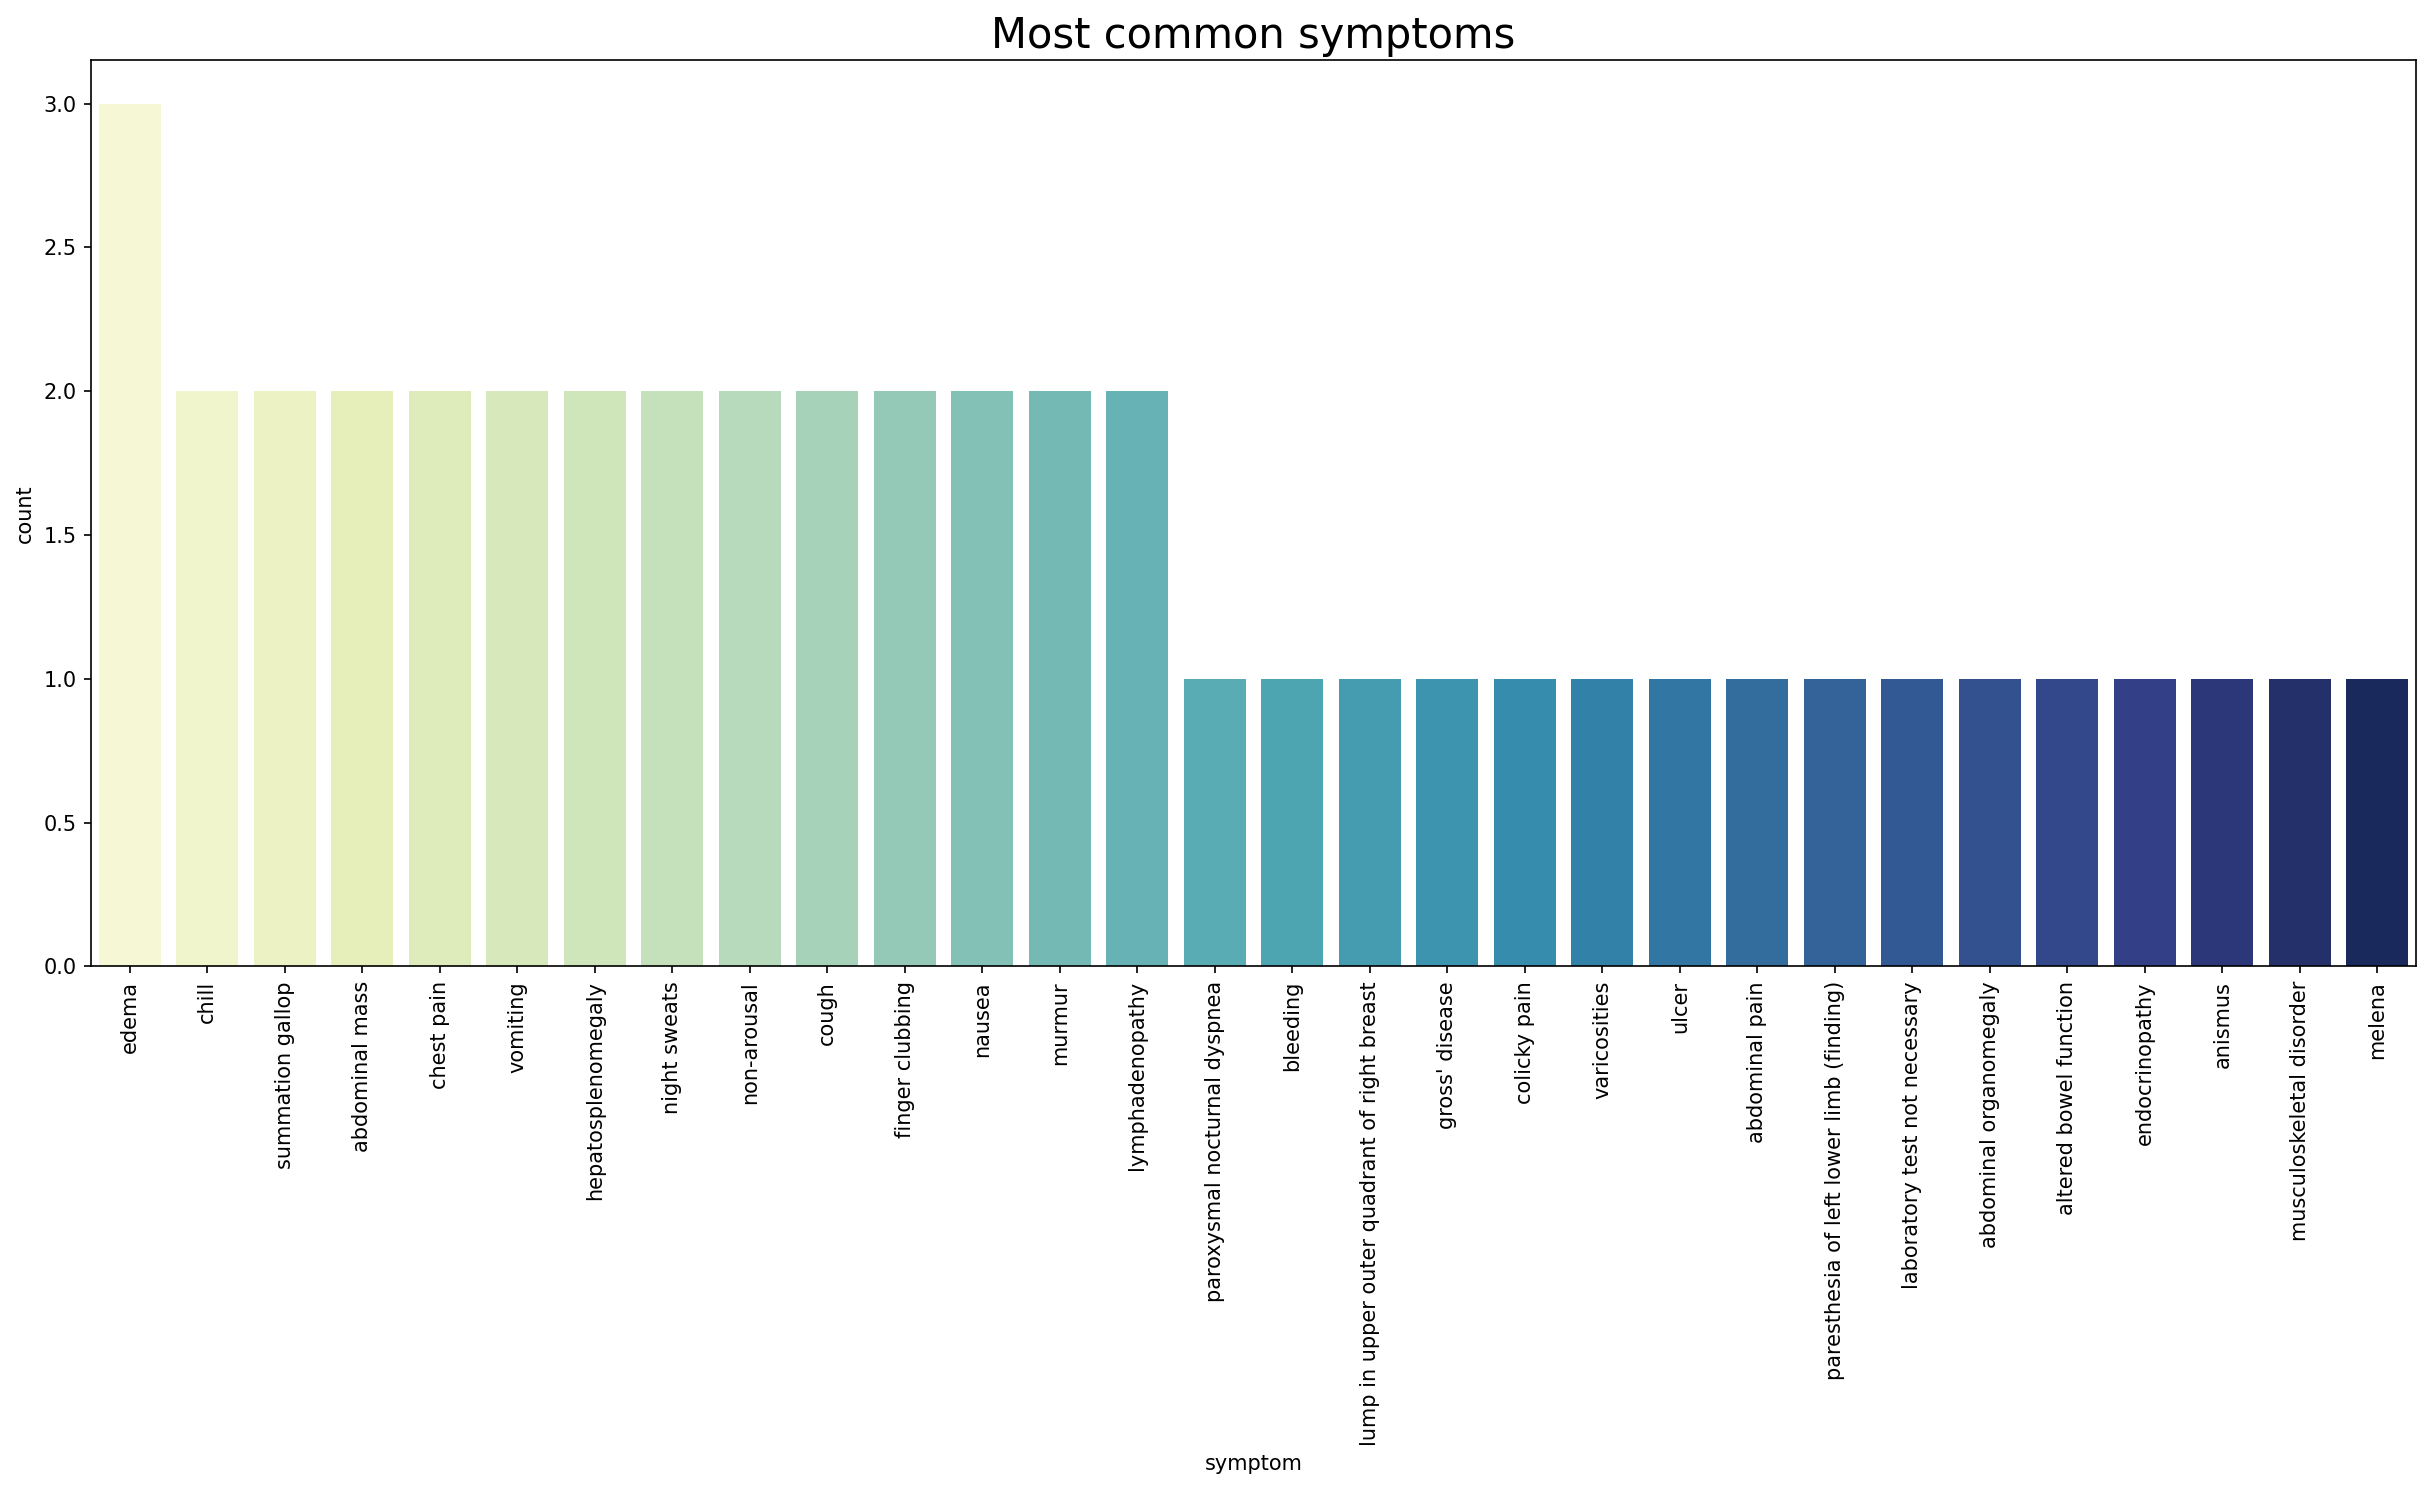

In [0]:
plt.figure(figsize=(20,8), dpi=150)
plt.xticks(rotation=90)
plt.title('Most common symptoms', size=20)
sns.countplot(unique_symptoms.symptom, order=most_common_symptoms, palette="YlGnBu")
plt.show()

## 1.7. Extract most frequent oncological diseases and symptoms based on documents
Here, we will count the number documents for each symptom-disease pair.

In [0]:
#Getting the list of the most common code names.
top_20_code_names = unique_icd_code_names.groupby("icd_codes_names").count().sort_values(by="path", ascending=False).iloc[:20].index
 
#Getting the list of common symptoms.
top_20_symptom = unique_symptoms.groupby("symptom").count().sort_values(by="path", ascending=False).iloc[:20].index

In [0]:
merged_df = pd.merge(unique_icd_code_names[unique_icd_code_names.icd_codes_names.isin(top_20_code_names)],
                     unique_symptoms[unique_symptoms.symptom.isin(top_20_symptom)],
                     on = "path").groupby(["icd_codes_names", "symptom"]).count().reset_index()
 
sympytom_cancer = merged_df.pivot_table(index="symptom", columns=["icd_codes_names"], values="path", fill_value=0)
 
sympytom_cancer

Out[46]:

icd_codes_names,breast cancer,breast composition,breast present,cancer,cancer of stomach,cf,eccrine ductal carcinoma,hematologic malignancy,lobular carcinoma in situ of left breast,malignant mesothelioma,mesothelioma,oropharyngeal lesion
symptom,,,,,,,,,,,,
abdominal mass,1,1,1,1,0,1,1,0,1,1,1,0
chest pain,1,1,1,1,0,1,1,0,1,1,1,0
chill,1,1,1,0,1,1,1,1,1,0,0,1
cough,1,1,1,1,0,1,1,0,1,1,1,0
edema,1,1,1,1,1,1,1,1,1,1,1,1
finger clubbing,1,1,1,1,0,1,1,0,1,1,1,0
hepatosplenomegaly,1,1,1,0,1,1,1,1,1,0,0,1
lymphadenopathy,0,0,0,1,1,0,0,1,0,1,1,1
murmur,1,1,1,0,1,1,1,1,1,0,0,1


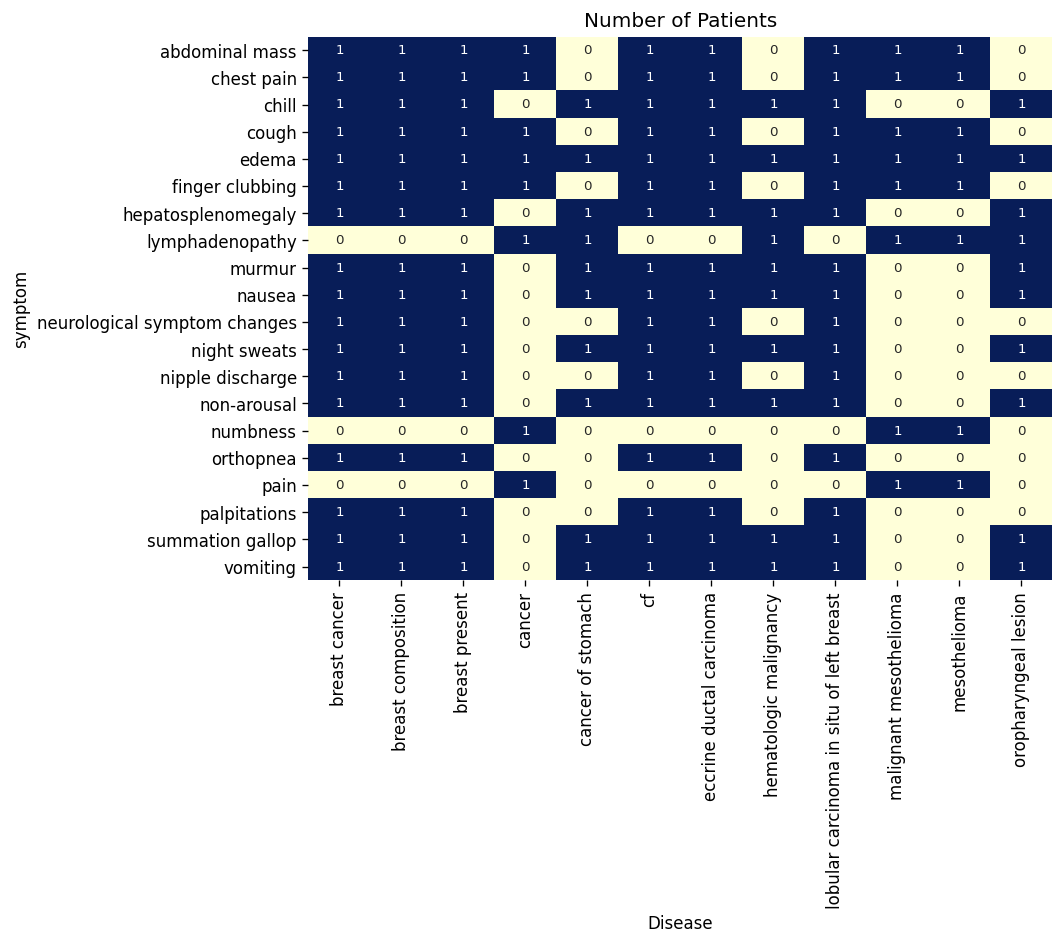

In [0]:
plt.figure(figsize=(8,6), dpi=120)
sns.heatmap(sympytom_cancer, annot=True, cbar=False, annot_kws={"size": 8}, cmap = "YlGnBu")
plt.title('Number of Patients')
plt.xlabel('Disease')
plt.show()

# 2. Get Drug codes from the notes

We will create a new pipeline to get drug codes. As NER model, we are using `ner_posology_large` and setting NerConverter's WhiteList `['DRUG']` in order to get only drug entities.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

## to get drugs
drugs_ner_ing = MedicalNerModel.pretrained("ner_posology_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")

drugs_ner_converter_ing = NerConverter() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["DRUG"])
  
drugs_c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

sbert_embedder_ing = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

rxnorm_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_rxnorm","en", "clinical/models")\
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

pipeline_rxnorm_ingredient = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_ing,
        drugs_ner_converter_ing, 
        drugs_c2doc, 
        sbert_embedder_ing,
        rxnorm_resolver])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_model = pipeline_rxnorm_ingredient.fit(data_ner)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_large download started this may take some time.
Approximate size to download 13.8 MB
[ | ][ / ][ — ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
demo_sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]

**Visualize Drug Entities** 

Now we will visualize a sample text with `NerVisualizer`.

In [0]:
sample_text = df.select("text").collect()[1]

print(sample_text)

Row(text='Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.\nPAST MEDICAL HISTORY\n1. Pericardectomy.\n2. Pericarditis.\n2. Atrial fibrillation.\n4. RNCA with intracranial thrombolytic treatment.\n5 PTA of MCA.\n6. Mesenteric venous thrombosis.\n7. Pericardial window.\n8. Cholecystectomy.\n9. Left thoracentesis.\nFAMILY HISTORY:\nNo family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.\nSOCIAL HISTORY:\nShe is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.\nMEDICATIONS\n1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.\n2. Amiodarone 100 mg p.o. daily.\nREVIEW OF SYSTEMS:\nComplete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.\nPHYSICAL EXAMINATION\nVITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.\nGENERAL: Positive nonproductive cough and pain with coughing.\nHEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.\nNECK: Supple. No lymphadenopathy. No masses.\nRESPIRATORY: Pleural friction rub is noted.\nGI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.\nEXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.\nSKIN: No breakdown or lesions. No ulcers.\nNEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.\nLABORATORY DATA:\nLabs are pending.\nHOSPITAL COURSE:\nThe patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid bio

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `rxnorm_model`.

In [0]:
light_model =  LightPipeline(rxnorm_model)

ann_text = light_model.fullAnnotate(sample_text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'sentence_embeddings', 'token', 'rxnorm_code', 'ner_drug', 'embeddings', 'ner_chunk_doc', 'sentence'])

In [0]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin DRUG 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone DRUG 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox DRUG 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which reve

**Checking all posology entities `DRUG`, `FREQUENCY`, `DURATION`, `STRENGTH`, `FORM`, `DOSAGE` and `ROUTE` by using `ner_posology_greedy` model without  setting a `WhiteList`.**

**So, if you want to find just the posology entities in greedy form, here is the pipeline you can use.**

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")
posology_greedy_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[ | ][ / ][ — ][OK!]

In [0]:
light_model =  LightPipeline(posology_greedy_model)
light_result = light_model.fullAnnotate(sample_text)[0]

In [0]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
# visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(light_result, label_col='ner_chunk_greedy',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg DRUG daily FREQUENCY . Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o DRUG . daily FREQUENCY . REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were per

**Now we will transform our dataframe by usig `rxnorm_model` and get RxNORM codes of the entities.**

In [0]:
rxnorm_code_res = rxnorm_model.transform(df) 

We are getting selecting the columns which we need and converting to Pandas DataFrame. The values in `all_codes` and `resolitions` columns are seperated by ":::" and we are converting these columns to lists.

In [0]:
rxnorm_res = rxnorm_code_res.select("path", F.explode(F.arrays_zip( 'ner_chunk.result', 'rxnorm_code.result', 'rxnorm_code.metadata')).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("drug_chunk"),
                                            F.expr("cols['1']").alias("rxnorm_code"),
                                            F.expr("cols['2']['confidence']").alias("confidence"),
                                            F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                            F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()


codes = []
resolutions = []

for code, resolution in zip(rxnorm_res['all_codes'], rxnorm_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_res['all_codes'] = codes  
rxnorm_res['resolutions'] = resolutions
rxnorm_res['drugs'] = rxnorm_res['resolutions'].apply(lambda x : x[0])

In [0]:
rxnorm_res.head(10)

Out[27]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,file:/databricks/driver/mt_oncology_2.txt,vaccine,540518,0.0928,"[540518, 583411, 890964, 253196, 1546597, 2058509, 1344, 218670, 204240, 1649574, 1250668, 34649...","[vopac, boostrix, program, respiratory vaccine, paccal, duvelisib, bcg vaccine, neo-tab, imferon...",vopac
1,file:/databricks/driver/mt_oncology_2.txt,vaccine,540518,0.0928,"[540518, 583411, 890964, 253196, 1546597, 2058509, 1344, 218670, 204240, 1649574, 1250668, 34649...","[vopac, boostrix, program, respiratory vaccine, paccal, duvelisib, bcg vaccine, neo-tab, imferon...",vopac
2,file:/databricks/driver/mt_oncology_2.txt,Aspirin,1191,0.6822,"[1191, 405403, 218266, 215448, 215568, 1154070, 215803, 1154069, 215436, 216110, 215444, 202547,...","[aspirin, ysp aspirin, med aspirin, aspirin-antacid, bayer aspirin, aspirin pill, ctd aspirin, a...",aspirin
3,file:/databricks/driver/mt_oncology_2.txt,Calan SR,215840,0.0763,"[215840, 605102, 1088135, 153100, 1086286, 1670019, 631232, 151138, 224894, 215809, 994240, 1428...","[caldecort, calafol rx, roc-cal, calcort, ca-rezz, cedrol, caldesene, calcilat, calcimar, cala-g...",caldecort
4,file:/databricks/driver/mt_oncology_2.txt,Platelets,385748,0.4597,"[385748, 1181786, 4388, 545405, 118785, 801388, 33834, 219267, 358340, 33835, 219118, 1488062, 1...","[platet, platet oral product, plasmin, plasbumin, plasmatein, plasma-lyte r, plasmalyte a, pleta...",platet
5,file:/databricks/driver/mt_oncology_2.txt,Tamoxifen,10324,0.1238,"[10324, 38409, 152404, 10869, 10763, 77492, 539402, 38868, 52769, 38998, 484821, 1245031, 220239...","[tamoxifen, toremifene, tamofen, tropicamide, triamterene, tamsulosin, taladine, tromantadine, m...",tamoxifen
6,file:/databricks/driver/mt_oncology_2.txt,Tamoxifen,10324,0.1238,"[10324, 38409, 152404, 10869, 10763, 77492, 539402, 38868, 52769, 38998, 484821, 1245031, 220239...","[tamoxifen, toremifene, tamofen, tropicamide, triamterene, tamsulosin, taladine, tromantadine, m...",tamoxifen
7,file:/databricks/driver/mt_oncology_2.txt,Nolvadex,281964,0.2342,"[281964, 93509, 204352, 226914, 82050, 218792, 544125, 203014, 996240, 2257602, 93558, 218760, 2...","[nolvadex, nolahist, noludar, novonorm, novantrone, novarel, novacort, noxyflex-s, novagest, nol...",nolvadex
8,file:/databricks/driver/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
9,file:/databricks/driver/mt_oncology_0.txt,Amiodarone,703,0.6925,"[703, 544501, 1663223, 484718, 1151983, 1151982, 577358, 1663270, 203114, 1151981, 377132, 54450...","[amiodarone, aniodarone, amiodarone injection, aminodarone, amiodarone pill, amiodarone oral pro...",amiodarone


## 2.1. Analyze drug usage patterns for inventory management and reporting

We are checking how many times any drug are encountered in the documents.

In [0]:
rxnorm_res.head()

Out[28]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,file:/databricks/driver/mt_oncology_2.txt,vaccine,540518,0.0928,"[540518, 583411, 890964, 253196, 1546597, 2058509, 1344, 218670, 204240, 1649574, 1250668, 34649...","[vopac, boostrix, program, respiratory vaccine, paccal, duvelisib, bcg vaccine, neo-tab, imferon...",vopac
1,file:/databricks/driver/mt_oncology_2.txt,vaccine,540518,0.0928,"[540518, 583411, 890964, 253196, 1546597, 2058509, 1344, 218670, 204240, 1649574, 1250668, 34649...","[vopac, boostrix, program, respiratory vaccine, paccal, duvelisib, bcg vaccine, neo-tab, imferon...",vopac
2,file:/databricks/driver/mt_oncology_2.txt,Aspirin,1191,0.6822,"[1191, 405403, 218266, 215448, 215568, 1154070, 215803, 1154069, 215436, 216110, 215444, 202547,...","[aspirin, ysp aspirin, med aspirin, aspirin-antacid, bayer aspirin, aspirin pill, ctd aspirin, a...",aspirin
3,file:/databricks/driver/mt_oncology_2.txt,Calan SR,215840,0.0763,"[215840, 605102, 1088135, 153100, 1086286, 1670019, 631232, 151138, 224894, 215809, 994240, 1428...","[caldecort, calafol rx, roc-cal, calcort, ca-rezz, cedrol, caldesene, calcilat, calcimar, cala-g...",caldecort
4,file:/databricks/driver/mt_oncology_2.txt,Platelets,385748,0.4597,"[385748, 1181786, 4388, 545405, 118785, 801388, 33834, 219267, 358340, 33835, 219118, 1488062, 1...","[platet, platet oral product, plasmin, plasbumin, plasmatein, plasma-lyte r, plasmalyte a, pleta...",platet


In [0]:
print(rxnorm_res.drugs.value_counts())

coumadin 3
iron supplement 2
vopac 2
tamoxifen 2
poldine 2
chemdec 2
lovenox 2
iron 2
liquid 1
levatol 1
nolvadex 1
altafed 1
phenergan 1
cisplatin 1
penicillin 1
amiodarone 1
caldecort 1
platet 1
heparin 1
aspirin 1
sus scrofa red blood cell preparation 1
vyvanse 1
zofran 1
Name: drugs, dtype: int64

## 2.2. Analyze most frequent used drugs for different cancer patients

For each drug, we are counting the unique documents encountered.

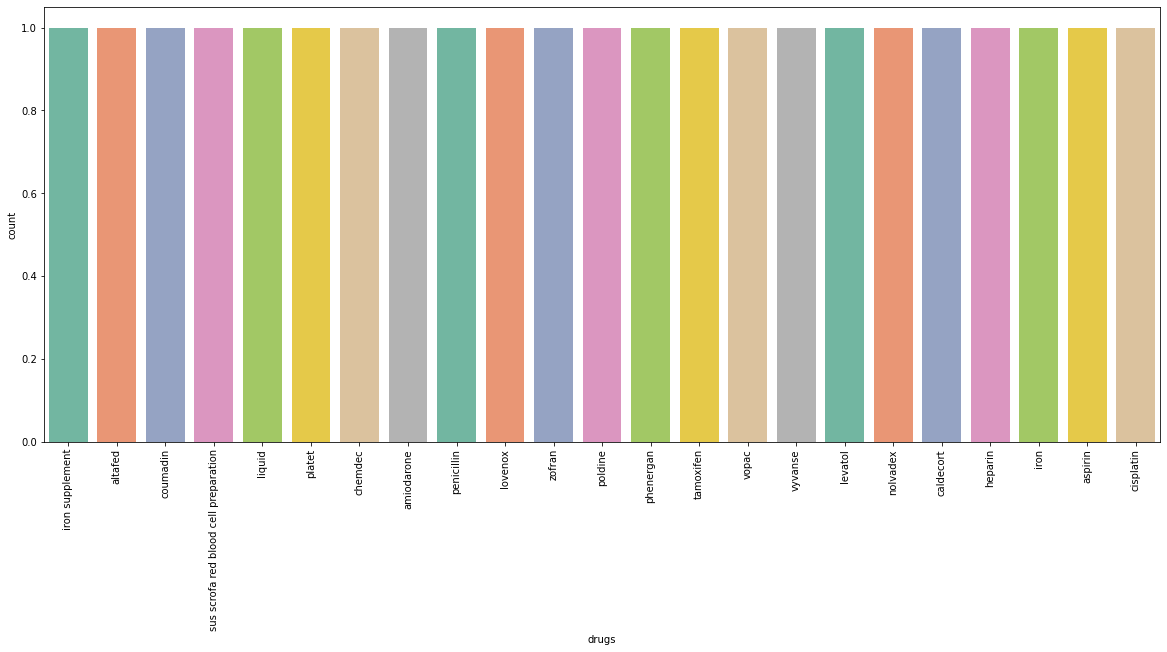

In [0]:
unique_drugs = rxnorm_res.groupby(["path","drugs"]).count().reset_index()[["path","drugs"]]	

plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

sns.countplot(unique_drugs.drugs, order=unique_drugs.drugs.value_counts().head(30).index, palette="Set2")
plt.show()

# 3. Get Timeline Using RE Models

We will create a relation extration model to identify temporal relationships among clinical events by using pretrained **RelationExtractionModel** `re_temporal_events_clinical`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencerDL_hc = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

events_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner_tags")  

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel.pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = Pipeline(stages=[
  documentAssembler,
  sentencerDL_hc,
  tokenizer, 
  word_embeddings, 
  pos_tagger, 
  events_ner_tagger,
  ner_chunker,
  dependency_parser,
  clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][ / ][ — ][OK!]
ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
[ | ][ / ][ — ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ][ / ][ — ][ \ ][OK!]

**Selecting the columns we need and transforming to Pandas Dataframe.**

In [0]:
temporal_re_df = model.transform(df)

In [0]:
temporal_re_pd_df = temporal_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['0']").alias("relation"),
                                          F.expr("cols['1']['entity1']").alias('entity1'),
                                          F.expr("cols['1']['chunk1']").alias('chunk1'),
                                          F.expr("cols['1']['entity2']").alias('entity2'),
                                          F.expr("cols['1']['chunk2']").alias('chunk2'),
                                          F.expr("cols['1']['confidence']").alias('confidence')
                                         ).toPandas()

In [0]:
temporal_re_pd_df.head(40)

Out[87]:

,path,relation,entity1,chunk1,entity2,chunk2,confidence
0,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,EVIDENTIAL,presents,EVIDENTIAL,complaint,0.9999995
1,file:/databricks/driver/mt_oncology_2.txt,BEFORE,EVIDENTIAL,presents,PROBLEM,lump in the upper outer quadrant,1.0
2,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,EVIDENTIAL,complaint,PROBLEM,lump in the upper outer quadrant,0.97861314
3,file:/databricks/driver/mt_oncology_2.txt,BEFORE,EVIDENTIAL,diagnosed,PROBLEM,breast cancer,0.9999918
4,file:/databricks/driver/mt_oncology_2.txt,AFTER,OCCURRENCE,presented,DURATION,4 weeks,0.9953105
5,file:/databricks/driver/mt_oncology_2.txt,BEFORE,PROBLEM,The lump,PROBLEM,painless and the skin,0.98212653
6,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,PROBLEM,The lump,EVIDENTIAL,denies,0.99962354
7,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,PROBLEM,painless and the skin,PROBLEM,the lump,0.9861799
8,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,PROBLEM,painless and the skin,EVIDENTIAL,denies,0.9858985
9,file:/databricks/driver/mt_oncology_2.txt,OVERLAP,PROBLEM,painless and the skin,PROBLEM,any redness,0.9987204


# 4. Analyze the Relations Between Body Parts and Procedures

We will create a relation extration model to identify relationships between body parts and problem entities by using pretrained **RelationExtractionModel** `re_bodypart_problem`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencerDL_hc = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel() \
    .pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_tags")

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner_tags"]) \
    .setOutputCol("ner_chunks_re")\
    .setWhiteList(['Internal_organ_or_component', 'Problem', 'Procedure'])

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["sentence", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

re_model = RelationExtractionModel()\
    .pretrained('re_bodypart_problem', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks_re", "dependencies"]) \
    .setOutputCol("relations")

bodypart_re_pipeline = Pipeline(stages=[documentAssembler, 
                            sentencerDL_hc, 
                            tokenizer, 
                            pos_tagger, 
                            word_embeddings, 
                            ner_tagger, 
                            ner_converter,
                            dependency_parser,
                            re_model])


empty_data = spark.createDataFrame([['']]).toDF("text")
bodypart_re_model = bodypart_re_pipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][ — ][ \ ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][OK!]
re_bodypart_problem download started this may take some time.
Approximate size to download 9.2 MB
[ | ][ / ][OK!]

In [0]:
bodypart_re_df = bodypart_re_model.transform(df)

In [0]:
bodypart_relation = bodypart_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['0']").alias("relation"),
                                          F.expr("cols['1']['entity1']").alias('entity1'),
                                          F.expr("cols['1']['chunk1']").alias('chunk1'),
                                          F.expr("cols['1']['entity2']").alias('entity2'),
                                          F.expr("cols['1']['chunk2']").alias('chunk2')
                                          ).toPandas()

## 4.1. Extract internal bodypart and procedure relations

We are filtering the dataframe to select rows with following conditions to see the relations between different entities.
* `entity1 != entity2'`

In [0]:
bodypart_relation = bodypart_relation[bodypart_relation.entity1!=bodypart_relation.entity2].drop_duplicates()
bodypart_relation

Out[95]:

,path,relation,entity1,chunk1,entity2,chunk2
0,file:/databricks/driver/mt_oncology_2.txt,1,Procedure,excisional biopsy,Internal_organ_or_component,axillary nodal
1,file:/databricks/driver/mt_oncology_2.txt,1,Procedure,lumpectomy,Internal_organ_or_component,axillary node
11,file:/databricks/driver/mt_oncology_1.txt,0,Procedure,bone marrow biopsy,Internal_organ_or_component,cellular marrow


**We can see the procedures applied to internal organs**

# 5. Get Procedure codes from notes

We will create a new pipeline to get procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical` and setting NerConverter's WhiteList `['Procedure']` in order to get only drug entities.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

proc_ner = MedicalNerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_proc")

proc_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner_proc"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['Procedure'])

proc_c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

proc_sbert_embedder = BertSentenceEmbeddings\
    .pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

cpt_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_cpt","en", "clinical/models")\
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")

bert_pipeline_cpt = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        proc_ner,
        proc_ner_converter, 
        proc_c2doc, 
        proc_sbert_embedder,
        cpt_resolver])
empty_data = spark.createDataFrame([['']]).toDF("text")
cpt_model = bert_pipeline_cpt.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
demo_sbiobertresolve_cpt download started this may take some time.
Approximate size to download 3.1 MB
[ | ][OK!]

In [0]:
cpt_model_res = cpt_model.transform(df)

In [0]:
cpt_res = cpt_model_res.select("path", F.explode(F.arrays_zip( 'ner_chunk.result', 'ner_chunk.metadata', 'cpt_code.result', 'cpt_code.metadata')).alias("cols"))\
                          .select("path", F.expr("cols['0']").alias("chunks"),
                                          F.expr("cols['1']['entity']").alias("entity"),
                                          F.expr("cols['2']").alias("cpt_code"),
                                          F.expr("cols['3']['confidence']").alias("confidence"),
                                          F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                          F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(cpt_res['all_codes'], cpt_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
cpt_res['all_codes'] = codes  
cpt_res['resolutions'] = resolutions
cpt_res['cpt'] = cpt_res['resolutions'].apply(lambda x : x[0])

In [0]:
cpt_res.head()

Out[99]:

,path,chunks,entity,cpt_code,confidence,all_codes,resolutions,cpt
0,file:/databricks/driver/mt_oncology_2.txt,excisional biopsy,Procedure,44950,0.1747,"[44950, 44820, 50290, 31420, 49215, 43610, 44005, 60280, 19112, 43611, 32100, 49010, 44025, 5890...","[Appendectomy, Excision of lesion of mesentery (separate procedure), Excision of perinephric cys...",Appendectomy
1,file:/databricks/driver/mt_oncology_2.txt,lumpectomy,Procedure,19304,0.1609,"[19304, 39200, 39220, 19301, 19302, 31420, 32505, 32310, 31375, 32320, 49215, 63191, 19371, 4760...","[Mastectomy, subcutaneous, Resection of mediastinal cyst, Resection of mediastinal tumor, Mastec...","Mastectomy, subcutaneous"
2,file:/databricks/driver/mt_oncology_2.txt,sigmoidoscopy,Procedure,43810,0.1263,"[43810, 47720, 44620, 47765, 44020, 44186, 44147, 43870, 47721, 47760, 43880, 45112, 44300, 4495...","[Gastroduodenostomy, Cholecystoenterostomy; direct , Closure of enterostomy, large or small inte...",Gastroduodenostomy
3,file:/databricks/driver/mt_oncology_2.txt,colonoscopy,Procedure,44620,0.1560,"[44620, 44320, 44650, 47760, 47765, 47720, 47721, 44188, 44626, 47740, 47715, 44025, 43810, 4414...","[Closure of enterostomy, large or small intestine, Colostomy or skin level cecostomy;, Closure o...","Closure of enterostomy, large or small intestine"
4,file:/databricks/driver/mt_oncology_2.txt,Appendectomy,Procedure,44950,0.9998,"[44950, 31420, 44147, 44820, 47600, 44850, 44620, 31400, 32100, 27290, 25927, 19328, 63191, 4921...","[Appendectomy, Epiglottidectomy , Colectomy, partial; abdominal and transanal approach, Excision...",Appendectomy


## 5.1. See most common procedures being performed

Let's count the number of each procedures and plot it.

In [0]:
#top 20
cpt_res['cpt'].value_counts().reset_index().head(20)

Out[100]:

,index,cpt
0,Decortication and parietal pleurectomy,6
1,Thoracotomy; with exploration,5
2,Thoracoscopy; with biopsy(ies) of pleura,3
3,Cholecystectomy;,2
4,Appendectomy,2
5,"Mastectomy, subcutaneous",2
6,Colostomy or skin level cecostomy;,1
7,Epiglottidectomy,1
8,Cervical lymphadenectomy (modified radical neck dissection),1
9,Gastroduodenostomy,1


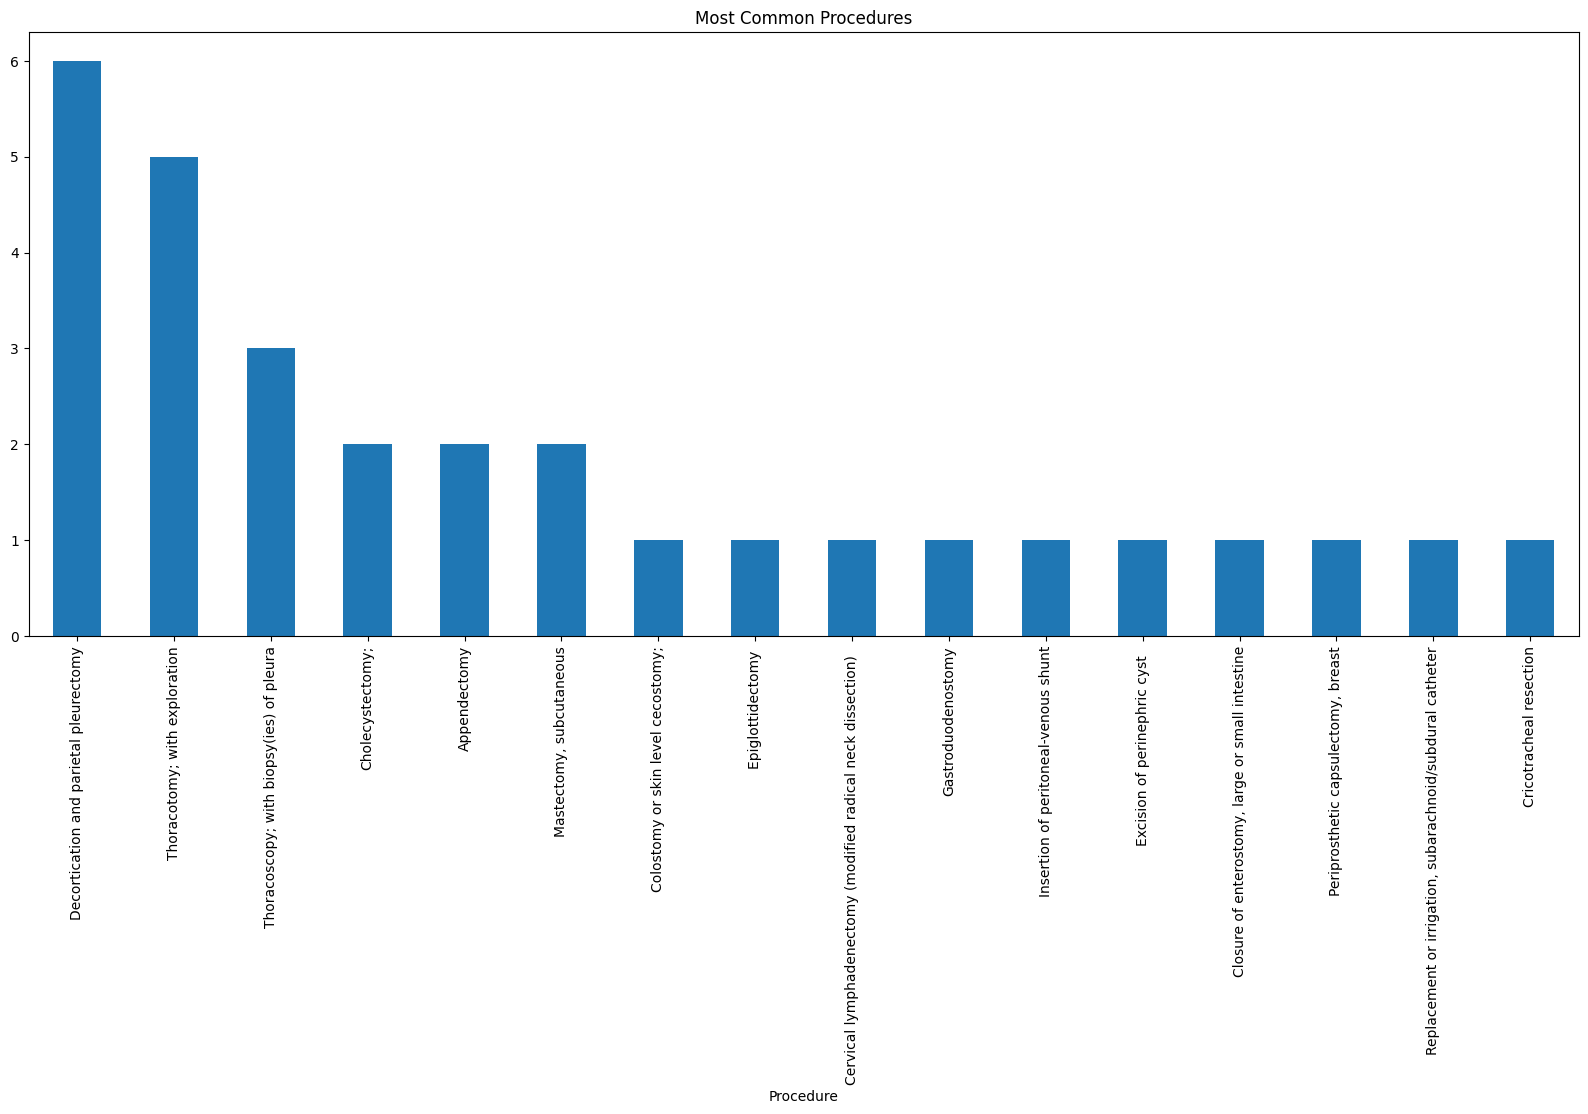

In [0]:
plt.figure(figsize=(20,8),dpi=100)
cpt_res['cpt'].value_counts().head(20).plot.bar()
plt.title('Most Common Procedures')
plt.xlabel("Procedure")
plt.show()

# 6. Get Assertion Status of Cancer Entities

We will create a new pipeline to get assertion status of cancer entities procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("bionlp_ner")

bionlp_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "bionlp_ner"]) \
    .setOutputCol("bionlp_ner_chunk")\
    .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Oncological", "Symptom"])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('bionlp_ner_chunk', "jsl_ner_chunk")\
    .setOutputCol('final_ner_chunk')

cancer_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "final_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")


assertion_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        cancer_assertion
    ])
empty_data = spark.createDataFrame([['']]).toDF("text")
assertion_model = assertion_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[ | ][ / ][OK!]

In [0]:
assertion_res = assertion_model.transform(df)

In [0]:
assertion_df = assertion_res.select("path", F.explode(F.arrays_zip('final_ner_chunk.result', 'final_ner_chunk.metadata', 'assertion.result')).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("chunk"),
                                            F.expr("cols['1']['entity']").alias("entity"),
                                            F.expr("cols['2']").alias("assertion")).toPandas()

In [0]:
assertion_df.head(20)

Out[105]:

,path,chunk,entity,assertion
0,file:/databricks/driver/mt_oncology_2.txt,Breast Cancer,Oncological,present
1,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,present
2,file:/databricks/driver/mt_oncology_2.txt,breast,Cancer,present
3,file:/databricks/driver/mt_oncology_2.txt,breast cancer,Cancer,associated_with_someone_else
4,file:/databricks/driver/mt_oncology_2.txt,Lump,Symptom,present
5,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,present
6,file:/databricks/driver/mt_oncology_2.txt,painless,Symptom,present
7,file:/databricks/driver/mt_oncology_2.txt,lump,Symptom,present
8,file:/databricks/driver/mt_oncology_2.txt,redness,Symptom,absent
9,file:/databricks/driver/mt_oncology_2.txt,warmth,Symptom,absent


**We can find the number of family members of cancer patients with cancer or symptoms**

In [0]:
print("Number of family members have cancer or symptoms: ", len(assertion_df[assertion_df.assertion=="associated_with_someone_else"]))

Number of family members have cancer or symptoms: 4

### 6.1 Use Case: Finding assertion status of the most common symptoms 

We will check if the symptom is absent or present.

In [0]:
assertion_df = assertion_df.drop_duplicates()
assertion_symptom = assertion_df[(assertion_df.assertion.isin(['present', 'absent'])) & (assertion_df.entity=="Symptom")]
most_common_symptoms = assertion_symptom.groupby(['path', 'assertion', 'chunk']).count().reset_index().chunk.value_counts().index[:20]

In [0]:
assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)]

Out[108]:

,path,chunk,entity,assertion
10,file:/databricks/driver/mt_oncology_2.txt,edema,Symptom,present
15,file:/databricks/driver/mt_oncology_2.txt,chills,Symptom,absent
16,file:/databricks/driver/mt_oncology_2.txt,night sweats,Symptom,absent
19,file:/databricks/driver/mt_oncology_2.txt,cough,Symptom,absent
21,file:/databricks/driver/mt_oncology_2.txt,chest pain,Symptom,absent
29,file:/databricks/driver/mt_oncology_2.txt,paroxysmal nocturnal dyspnea,Symptom,absent
31,file:/databricks/driver/mt_oncology_2.txt,nausea,Symptom,absent
32,file:/databricks/driver/mt_oncology_2.txt,vomiting,Symptom,absent
33,file:/databricks/driver/mt_oncology_2.txt,abdominal pain,Symptom,absent
40,file:/databricks/driver/mt_oncology_2.txt,murmurs,Symptom,absent


In [0]:
assertion_df["assertion"].value_counts()

Out[109]: absent 75
present 34
associated_with_someone_else 4
Name: assertion, dtype: int64

In [0]:
 assertion_df.groupby(["path","assertion"]).count().reset_index()

Out[110]:

,path,assertion,chunk,entity
0,file:/databricks/driver/mt_oncology_0.txt,absent,12,12
1,file:/databricks/driver/mt_oncology_0.txt,associated_with_someone_else,1,1
2,file:/databricks/driver/mt_oncology_0.txt,present,17,17
3,file:/databricks/driver/mt_oncology_1.txt,absent,21,21
4,file:/databricks/driver/mt_oncology_1.txt,associated_with_someone_else,1,1
5,file:/databricks/driver/mt_oncology_1.txt,present,2,2
6,file:/databricks/driver/mt_oncology_2.txt,absent,42,42
7,file:/databricks/driver/mt_oncology_2.txt,associated_with_someone_else,2,2
8,file:/databricks/driver/mt_oncology_2.txt,present,15,15


In [0]:
assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)]

Out[111]:

,path,chunk,entity,assertion
10,file:/databricks/driver/mt_oncology_2.txt,edema,Symptom,present
15,file:/databricks/driver/mt_oncology_2.txt,chills,Symptom,absent
16,file:/databricks/driver/mt_oncology_2.txt,night sweats,Symptom,absent
19,file:/databricks/driver/mt_oncology_2.txt,cough,Symptom,absent
21,file:/databricks/driver/mt_oncology_2.txt,chest pain,Symptom,absent
29,file:/databricks/driver/mt_oncology_2.txt,paroxysmal nocturnal dyspnea,Symptom,absent
31,file:/databricks/driver/mt_oncology_2.txt,nausea,Symptom,absent
32,file:/databricks/driver/mt_oncology_2.txt,vomiting,Symptom,absent
33,file:/databricks/driver/mt_oncology_2.txt,abdominal pain,Symptom,absent
40,file:/databricks/driver/mt_oncology_2.txt,murmurs,Symptom,absent


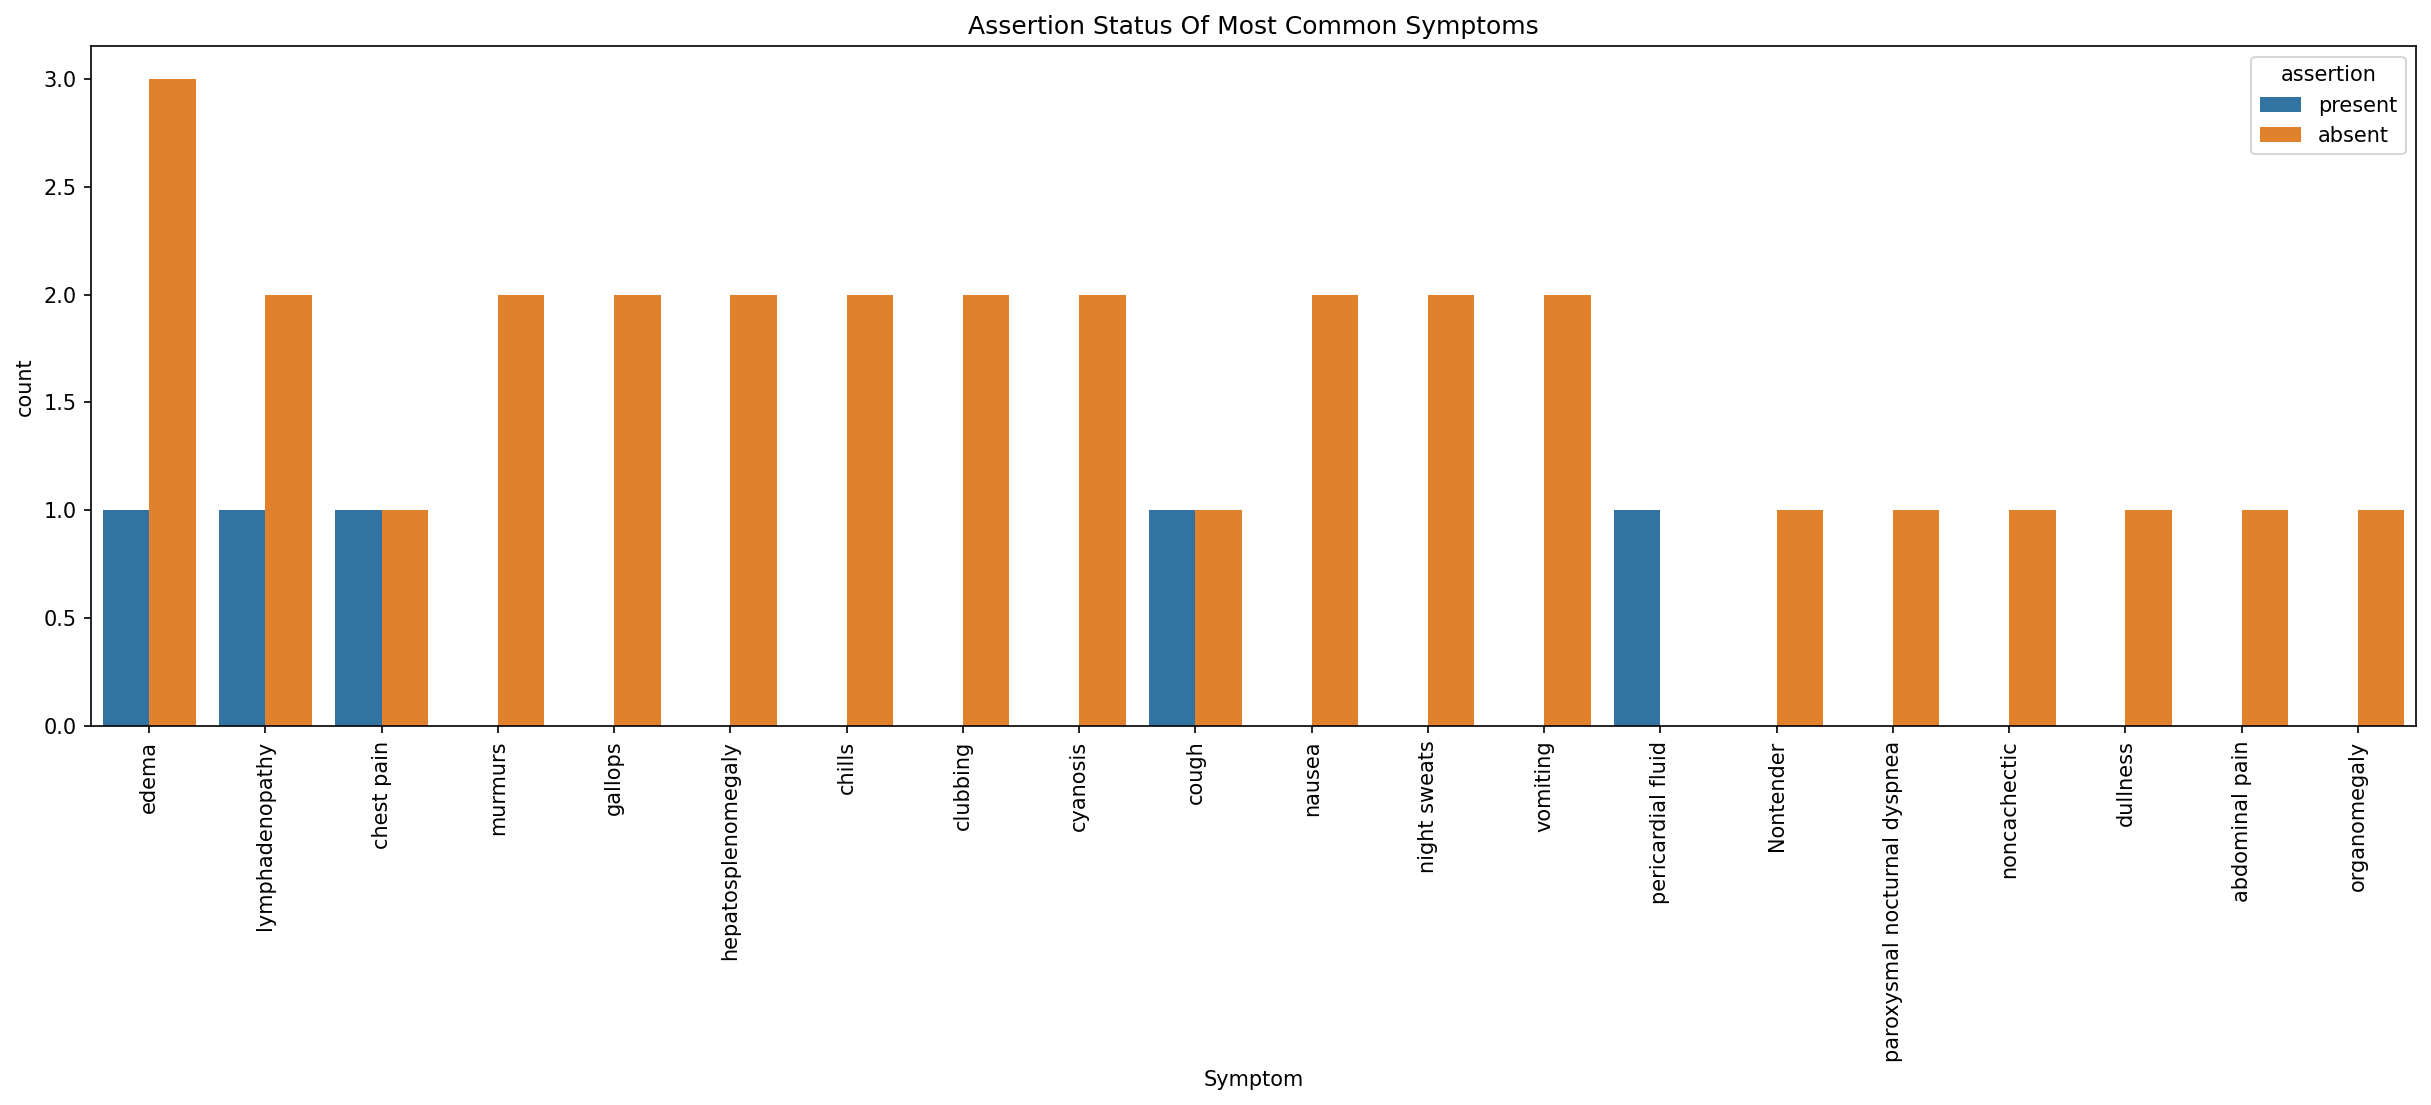

In [0]:
plt.figure(figsize=(20,6), dpi=150)
sns.countplot(x='chunk', data=assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)], hue='assertion', order=most_common_symptoms )
plt.xticks(rotation = 90)
plt.title("Assertion Status Of Most Common Symptoms")
plt.xlabel("Symptom")
plt.show()

**End Of Notebook**